**Load Dataset**

In [ ]:
from torch.utils.data import Dataset
import os
import torch

#Load dari file simpanan hasil preproses dalam bentuk .pt
class ProcessedVideoDataset(Dataset):
    def __init__(self, pt_folder):
        self.pt_folder = pt_folder
        self.pt_files = [os.path.join(pt_folder, f) for f in os.listdir(pt_folder) if f.endswith('.pt')]
        self.file_list = sorted([
            f for f in os.listdir(pt_folder)
            if f.endswith('.pt')
        ])

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        file_path = os.path.join(self.pt_folder, self.file_list[idx])
        data = torch.load(file_path)

        #Load frame wajah dan labelnya
        frames = torch.stack(data['frames'])
        label = data['label']

        return frames, label

In [2]:
from torch.utils.data import DataLoader, random_split

pt_folder = 'Dataset Deepfake Preprocessed/Preprocessed Wajah'
full_dataset = ProcessedVideoDataset(pt_folder)

# Split 80/20
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=0)

In [ ]:
import os

# Simpan file list dari train_set dan val_set
train_files = [full_dataset.pt_files[i] for i in train_dataset.indices]
val_files = [full_dataset.pt_files[i] for i in val_dataset.indices]

with open("Dataset_Skripsi/train_split_wajah.txt", "w") as f:
    f.writelines(f"{fpath}\n" for fpath in train_files)

with open("Dataset_Skripsi/val_split_wajah.txt", "w") as f:
    f.writelines(f"{fpath}\n" for fpath in val_files)

In [ ]:
class MultimodalDatasetFromList(Dataset):
    def __init__(self, list_path):
        with open(list_path, "r") as f:
            self.pt_files = [line.strip() for line in f.readlines()]

    def __len__(self):
        return len(self.pt_files)

    def __getitem__(self, idx):
        data = torch.load(self.pt_files[idx])
        return torch.stack(data['frames']), torch.tensor(data['label'], dtype=torch.long)

In [4]:
from torch.utils.data import DataLoader, random_split

train_set = MultimodalDatasetFromList("Dataset_Skripsi/train_split_wajah.txt")
val_set   = MultimodalDatasetFromList("Dataset_Skripsi/val_split_wajah.txt")

train_loader = DataLoader(train_set, batch_size=4, shuffle=True, num_workers=0)
val_loader   = DataLoader(val_set, batch_size=4, shuffle=False, num_workers=0)

In [3]:
# Cek panjang masing-masing
print(f"Jumlah data train: {len(train_dataset)}")
print(f"Jumlah data val  : {len(val_dataset)}")

# Lihat sample pertama dari train_set
frames, label = train_dataset[21]
print("=== TRAIN SET SAMPLE ===")
print(f"Frame shape: {frames.shape}")
print(f"Label      : {label} ({'REAL' if label == 0 else 'FACE-SWAP DEEPFAKE'})")

# Lihat sample pertama dari val_set
frames_val, label_val = val_dataset[21]
print("\n=== VALIDATION SET SAMPLE ===")
print(f"Frame shape: {frames_val.shape}")
print(f"Label      : {label_val} ({'REAL' if label_val == 0 else 'FACE-SWAP DEEPFAKE'})")

Jumlah data train: 238
Jumlah data val  : 60
=== TRAIN SET SAMPLE ===
Frame shape: torch.Size([50, 3, 224, 224])
Label      : 1 (FACE-SWAP DEEPFAKE)

=== VALIDATION SET SAMPLE ===
Frame shape: torch.Size([50, 3, 224, 224])
Label      : 0 (REAL)


**Preview Dataset**

Label: 0
Frames shape: torch.Size([50, 3, 224, 224])


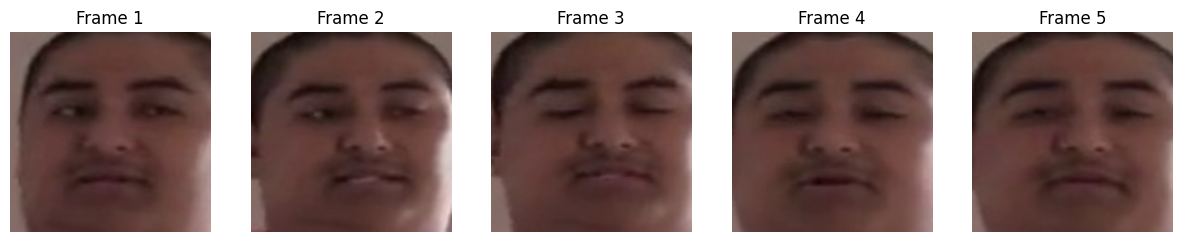

In [ ]:
import matplotlib.pyplot as plt

# Fungsi untuk preview 1 sample dataset
def preview_dataset(dataset, idx=0):
    frames, label = dataset[idx]

    print(f"Label: {label}")
    print(f"Frames shape: {frames.shape}")   # (T, 3, H, W)

    # Tampilkan 5 frame pertama
    num_frames_to_show = min(5, frames.size(0))
    fig, axes = plt.subplots(1, num_frames_to_show, figsize=(15, 5))
    
    for i in range(num_frames_to_show):
        img = frames[i].permute(1, 2, 0).numpy()  # (H, W, 3)
        img = (img * 255).astype('uint8')

        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(f"Frame {i+1}")

    plt.show()

# Contoh pakai train_dataset
preview_dataset(train_dataset, idx=0)

==========================

**AlexNet Convolution Block Overview**

(1) Conv Block (3, 64) -> ReLU

(2) Conv Block (64, 192) -> ReLU

(3) Conv Block (192, 384) -> ReLU

(4) Conv Block (384, 256) -> ReLU

(5) Conv Block (256, 256) -> ReLU

**Note : Buang Layer Pooling karena hanya mengambil layer konvolusi**

==========================

=========================================

**Coba Layer CNN**

=========================================

**Percobaan 1**

Full Conv Block (256, 256) -> ReLU

Weight Criterion 1:1

In [ ]:
import torch
import torch.nn as nn
from torchvision import models

# Model Fitur Ekstraktor
class AlexNetFeatureExtractor(nn.Module):
    def __init__(self):
        super(AlexNetFeatureExtractor, self).__init__()
        alexnet = models.alexnet(pretrained=True)
        for idx, layer in enumerate(alexnet.features.children()):
            for param in layer.parameters():
                param.requires_grad = False
        self.feature_extractor = nn.Sequential(*list(alexnet.features.children())[:-1])
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        

    def forward(self, x):
        B, T, C, H, W = x.shape
        x = x.view(B * T, C, H, W)       
        x = self.feature_extractor(x)       
        x = self.pool(x)                    
        x = x.view(B, T, -1)                
        return x

class AttentionLayer(nn.Module):
    def __init__(self, input_dim):
        super(AttentionLayer, self).__init__()
        self.attn = nn.Linear(input_dim, 1)

    def forward(self, x):
        weights = self.attn(x).squeeze(-1)
        weights = torch.softmax(weights, dim=1)
        attended = torch.sum(x * weights.unsqueeze(-1), dim=1)
        return attended

# Model Fitur Temporal
class BiLSTMDeepfake(nn.Module):
    def __init__(self, input_size=256, hidden_size=256, num_layers=2, dropout=0.3):
        super(BiLSTMDeepfake, self).__init__()
        self.lstm1 = nn.LSTM(input_size, hidden_size, num_layers=num_layers, batch_first=True,
                             bidirectional=True, dropout=dropout)
        self.lstm2 = nn.LSTM(hidden_size * 2, hidden_size, num_layers=num_layers, batch_first=True,
                             bidirectional=True, dropout=dropout)
        self.attention = AttentionLayer(hidden_size * 2)
        self.output_size = hidden_size * 2

    def forward(self, x):
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        attended = self.attention(x)  # (B, 2H)
        return attended

# Model Gabungan Fitur
class DeepfakeClassifier(nn.Module):
    def __init__(self, num_classes=2):
        super(DeepfakeClassifier, self).__init__()
        self.visual_extractor = AlexNetFeatureExtractor()
        self.bilstm = BiLSTMDeepfake()
        
        input_dim = self.bilstm.output_size
        
        self.classifier = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.LayerNorm(256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.LayerNorm(128),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(128, num_classes)
        )

    def forward(self, frames):
        visual_feat_seq = self.visual_extractor(frames)
        visual_embed = self.bilstm(visual_feat_seq)
        out = self.classifier(visual_embed)
        return out

In [23]:
import torch
import torch.nn as nn

# Inisialisasi perangkat dan model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DeepfakeClassifier().to(device)

# Optimizer dan loss function
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
weights = torch.tensor([1.0, 1.0], device=device)  # bobot kelas REAL, DEEPFAKE
criterion = nn.CrossEntropyLoss(weight=weights)

c:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [10]:
model.eval()

DeepfakeClassifier(
  (visual_extractor): AlexNetFeatureExtractor(
    (feature_extractor): Sequential(
      (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (4): ReLU(inplace=True)
      (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace=True)
      (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU(inplace=True)
      (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
    )
    (pool): AdaptiveAvgPool2d(output_size=(1, 1))
  )
  (bilstm): BiLSTMDeepfake(
    (lstm1): LSTM(256, 256, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True

In [ ]:
# Log
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

num_epochs = 40
best_val_loss = float('inf')

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    total_correct = 0
    total_samples = 0

    # Training
    for frames, labels in train_loader:
        frames = torch.stack(frames).to(device) if isinstance(frames, list) else frames.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(frames)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * frames.size(0)
        _, predicted = torch.max(outputs, 1)
        total_correct += (predicted == labels).sum().item()
        total_samples += labels.size(0)

    train_acc = total_correct / total_samples
    train_loss = running_loss / total_samples

    # Validasi
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for frames, labels in val_loader:
            frames = torch.stack(frames).to(device) if isinstance(frames, list) else frames.to(device)
            labels = labels.to(device)

            outputs = model(frames)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * frames.size(0)
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    val_acc = val_correct / val_total
    val_loss = val_loss / val_total

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    
    # Save best model dengan val loss terbaik
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'Model/AlexNet-BiLSTM_Wajah/AlexNet_256x256-BiLSTM_2_Wajah_1R1F.pth')
    
    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} "
          f"| Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

Epoch [1/40] Train Loss: 0.7092 | Train Acc: 0.5896 | Val Loss: 0.6876 | Val Acc: 0.5672
Epoch [2/40] Train Loss: 0.7148 | Train Acc: 0.4963 | Val Loss: 0.6557 | Val Acc: 0.6866
Epoch [3/40] Train Loss: 0.6925 | Train Acc: 0.5634 | Val Loss: 0.7696 | Val Acc: 0.4776
Epoch [4/40] Train Loss: 0.6742 | Train Acc: 0.5896 | Val Loss: 0.6839 | Val Acc: 0.5522
Epoch [5/40] Train Loss: 0.6555 | Train Acc: 0.6343 | Val Loss: 0.6635 | Val Acc: 0.5672
Epoch [6/40] Train Loss: 0.6244 | Train Acc: 0.6567 | Val Loss: 0.5915 | Val Acc: 0.6716
Epoch [7/40] Train Loss: 0.6194 | Train Acc: 0.6791 | Val Loss: 0.5411 | Val Acc: 0.7313
Epoch [8/40] Train Loss: 0.5764 | Train Acc: 0.6978 | Val Loss: 0.7186 | Val Acc: 0.5821
Epoch [9/40] Train Loss: 0.5596 | Train Acc: 0.7276 | Val Loss: 0.6873 | Val Acc: 0.6418
Epoch [10/40] Train Loss: 0.6066 | Train Acc: 0.6828 | Val Loss: 0.8555 | Val Acc: 0.5672
Epoch [11/40] Train Loss: 0.5601 | Train Acc: 0.7351 | Val Loss: 0.5994 | Val Acc: 0.7015
Epoch [12/40] Train

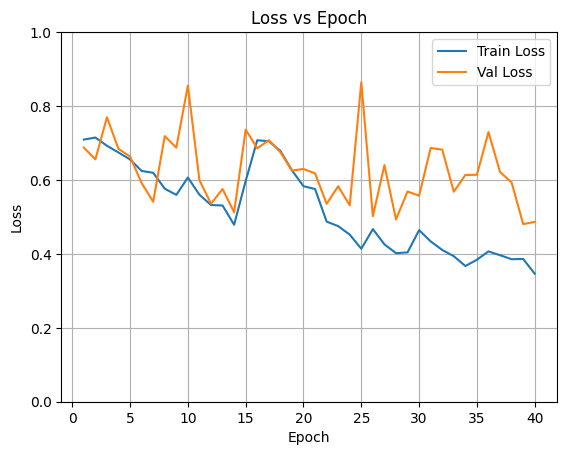

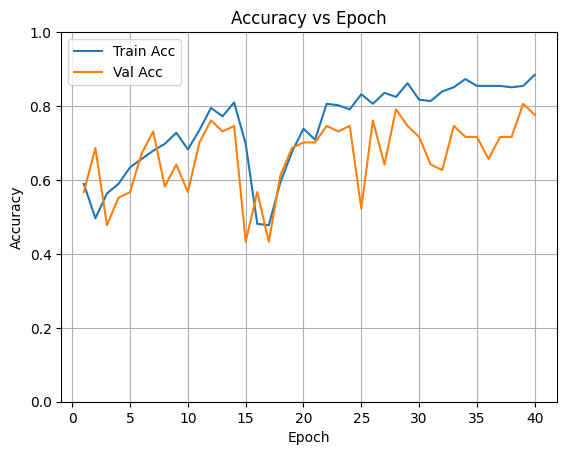

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, num_epochs + 1)

# Loss plot
plt.figure()
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.ylim(0, 1)  # Membatasi sumbu y dari 0 sampai 1
plt.legend()
plt.grid(True)
plt.show()

# Akurasi plot
plt.figure()
plt.plot(epochs, train_accuracies, label='Train Acc')
plt.plot(epochs, val_accuracies, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epoch')
plt.ylim(0, 1)  # Membatasi sumbu y dari 0 sampai 1
plt.legend()
plt.grid(True)
plt.show()

aabyjxwqyo.pt: Predicted = FACE-SWAP DEEPFAKE, True = FACE-SWAP DEEPFAKE
aaeflzzhvy.pt: Predicted = FACE-SWAP DEEPFAKE, True = FACE-SWAP DEEPFAKE
accfrqkrni.pt: Predicted = FACE-SWAP DEEPFAKE, True = FACE-SWAP DEEPFAKE
adfzvplbky.pt: Predicted = FACE-SWAP DEEPFAKE, True = FACE-SWAP DEEPFAKE
adrqlckutl.pt: Predicted = FACE-SWAP DEEPFAKE, True = FACE-SWAP DEEPFAKE
adsxwxeibr.pt: Predicted = FACE-SWAP DEEPFAKE, True = FACE-SWAP DEEPFAKE
ahencqpiin.pt: Predicted = FACE-SWAP DEEPFAKE, True = FACE-SWAP DEEPFAKE
alzbizkswy.pt: Predicted = FACE-SWAP DEEPFAKE, True = REAL
aqhbszcpal.pt: Predicted = FACE-SWAP DEEPFAKE, True = FACE-SWAP DEEPFAKE
baqledjaon.pt: Predicted = FACE-SWAP DEEPFAKE, True = FACE-SWAP DEEPFAKE
barbcborgl.pt: Predicted = FACE-SWAP DEEPFAKE, True = REAL
bfkzrgovsv.pt: Predicted = FACE-SWAP DEEPFAKE, True = REAL
bfljjbavig.pt: Predicted = FACE-SWAP DEEPFAKE, True = FACE-SWAP DEEPFAKE
bhqcqwcise.pt: Predicted = FACE-SWAP DEEPFAKE, True = REAL
bqwwkjlmgv.pt: Predicted = FACE-SW

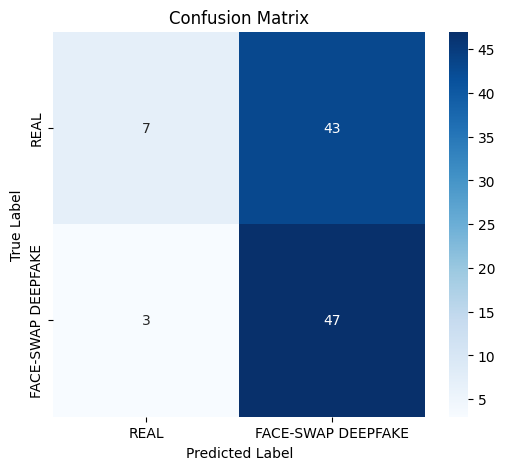


📊 Classification Report:
                    precision    recall  f1-score   support

              REAL       0.70      0.14      0.23        50
FACE-SWAP DEEPFAKE       0.52      0.94      0.67        50

          accuracy                           0.54       100
         macro avg       0.61      0.54      0.45       100
      weighted avg       0.61      0.54      0.45       100


📈 AUC Score: 0.4992


c:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\interpolate\_interpolate.py:701: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\interpolate\_interpolate.py:704: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


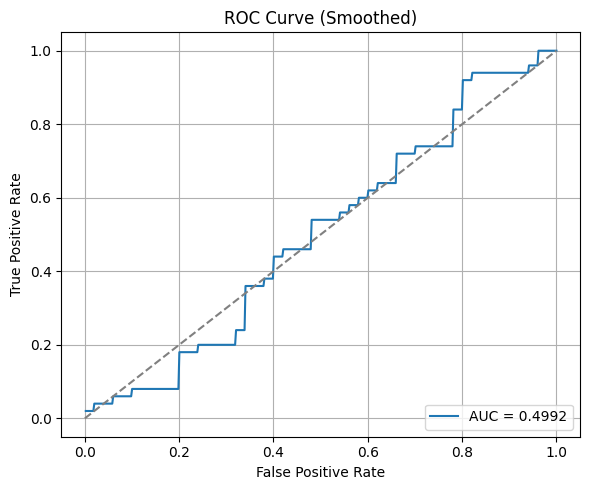

In [ ]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
from scipy.interpolate import interp1d


# Setup device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load model
def load_model(weights_path):
    model = DeepfakeClassifier()
    model.load_state_dict(torch.load(weights_path, map_location=device))
    model.to(device)
    model.eval()
    return model

# Path konfigurasi
model_path = "Model/AlexNet-BiLSTM_Wajah/AlexNet_256x256-BiLSTM_2_Wajah_1R1F.pth"
pt_folder = "Dataset_Skripsi/testing CNN-BiLSTM/Preprocessed_npy"
model = load_model(model_path)

classes = ['REAL', 'FACE-SWAP DEEPFAKE']
true_labels = []
predicted_labels = []
probs_class1 = []

# Loop seluruh file
for filename in sorted(os.listdir(pt_folder)):
    if not filename.endswith(".pt"):
        continue

    filepath = os.path.join(pt_folder, filename)
    data = torch.load(filepath)

    frames = torch.stack(data['frames']).unsqueeze(0).to(device)

    true_label = data['label'].item()

    with torch.no_grad():
        outputs = model(frames)
        probabilities = torch.softmax(outputs, dim=1).cpu().numpy()[0]
        predicted = int(np.argmax(probabilities))
        probs_class1.append(probabilities[1])

    print(f"{filename}: Predicted = {classes[predicted]}, True = {classes[true_label]}")

    true_labels.append(true_label)
    predicted_labels.append(predicted)

# Akurasi
total = len(true_labels)
correct = sum(p == t for p, t in zip(predicted_labels, true_labels))
accuracy = correct / total if total > 0 else 0
print(f"\n✅ Testing Accuracy: {accuracy * 100:.2f}% ({correct}/{total})")

# Confusion Matrix
cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print("\n📊 Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=classes))

# AUC Score
if len(set(true_labels)) == 2:
    auc_score = roc_auc_score(true_labels, probs_class1)
    print(f"\n📈 AUC Score: {auc_score:.4f}")

    # ROC Curve
    fpr, tpr, thresholds = roc_curve(true_labels, probs_class1)

    fpr_smooth = np.linspace(0, 1, 500)
    tpr_smooth = interp1d(fpr, tpr, kind='linear', fill_value="extrapolate")(fpr_smooth)

    # Plot
    plt.figure(figsize=(6, 5))
    plt.plot(fpr_smooth, tpr_smooth, label=f"AUC = {auc_score:.4f}")
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve (Smoothed)')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("\n⚠️ AUC tidak bisa dihitung karena hanya ada satu kelas di label.")

**Percobaan 2**

Full Conv Block (256, 256) -> ReLU

Weight Criterion 2:1

In [27]:
import torch
import torch.nn as nn

# Inisialisasi perangkat dan model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DeepfakeClassifier().to(device)

# Optimizer dan loss function
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
weights = torch.tensor([2.0, 1.0], device=device)  # bobot kelas REAL, DEEPFAKE
criterion = nn.CrossEntropyLoss(weight=weights)

c:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# Log
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

num_epochs = 40
best_val_loss = float('inf')

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    total_correct = 0
    total_samples = 0

    # Training
    for frames, labels in train_loader:
        frames = torch.stack(frames).to(device) if isinstance(frames, list) else frames.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(frames)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * frames.size(0)
        _, predicted = torch.max(outputs, 1)
        total_correct += (predicted == labels).sum().item()
        total_samples += labels.size(0)

    train_acc = total_correct / total_samples
    train_loss = running_loss / total_samples

    # Validasi
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for frames, labels in val_loader:
            frames = torch.stack(frames).to(device) if isinstance(frames, list) else frames.to(device)
            labels = labels.to(device)

            outputs = model(frames)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * frames.size(0)
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    val_acc = val_correct / val_total
    val_loss = val_loss / val_total

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    
    # Save model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'Model/AlexNet-BiLSTM_Wajah/AlexNet_256x256-BiLSTM_2_Wajah_2R1F.pth')
    
    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} "
          f"| Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

Epoch [1/40] Train Loss: 0.7117 | Train Acc: 0.5299 | Val Loss: 0.7112 | Val Acc: 0.4328
Epoch [2/40] Train Loss: 0.6837 | Train Acc: 0.4664 | Val Loss: 0.6748 | Val Acc: 0.4328
Epoch [3/40] Train Loss: 0.6299 | Train Acc: 0.5522 | Val Loss: 0.6847 | Val Acc: 0.4627
Epoch [4/40] Train Loss: 0.6442 | Train Acc: 0.5784 | Val Loss: 0.6395 | Val Acc: 0.5672
Epoch [5/40] Train Loss: 0.6489 | Train Acc: 0.5821 | Val Loss: 0.6604 | Val Acc: 0.5373
Epoch [6/40] Train Loss: 0.6226 | Train Acc: 0.6381 | Val Loss: 0.6095 | Val Acc: 0.5970
Epoch [7/40] Train Loss: 0.5765 | Train Acc: 0.6455 | Val Loss: 0.6010 | Val Acc: 0.5970
Epoch [8/40] Train Loss: 0.5732 | Train Acc: 0.6866 | Val Loss: 0.6771 | Val Acc: 0.5672
Epoch [9/40] Train Loss: 0.5415 | Train Acc: 0.6866 | Val Loss: 0.7131 | Val Acc: 0.4925
Epoch [10/40] Train Loss: 0.5825 | Train Acc: 0.6343 | Val Loss: 0.5539 | Val Acc: 0.6716
Epoch [11/40] Train Loss: 0.6277 | Train Acc: 0.5522 | Val Loss: 0.6578 | Val Acc: 0.4478
Epoch [12/40] Train

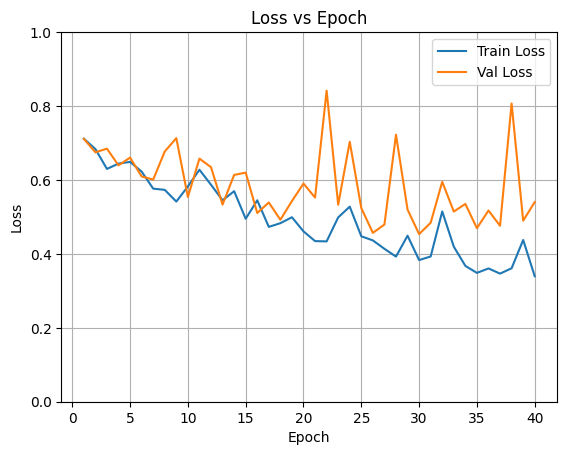

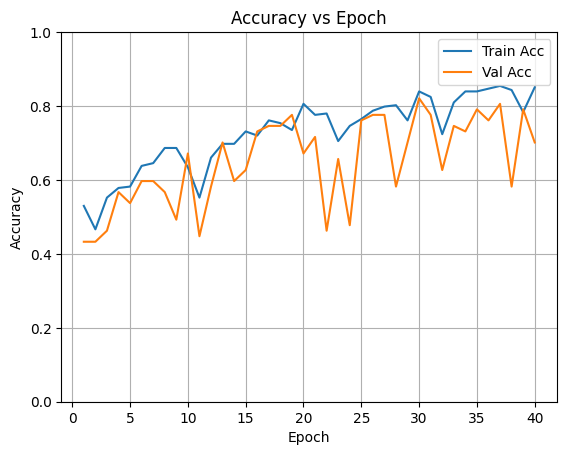

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, num_epochs + 1)

# Loss plot
plt.figure()
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.ylim(0, 1)  # Membatasi sumbu y dari 0 sampai 1
plt.legend()
plt.grid(True)
plt.show()

# Akurasi plot
plt.figure()
plt.plot(epochs, train_accuracies, label='Train Acc')
plt.plot(epochs, val_accuracies, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epoch')
plt.ylim(0, 1)  # Membatasi sumbu y dari 0 sampai 1
plt.legend()
plt.grid(True)
plt.show()

aabyjxwqyo.pt: Predicted = FACE-SWAP DEEPFAKE, True = FACE-SWAP DEEPFAKE
aaeflzzhvy.pt: Predicted = FACE-SWAP DEEPFAKE, True = FACE-SWAP DEEPFAKE
accfrqkrni.pt: Predicted = FACE-SWAP DEEPFAKE, True = FACE-SWAP DEEPFAKE
adfzvplbky.pt: Predicted = FACE-SWAP DEEPFAKE, True = FACE-SWAP DEEPFAKE
adrqlckutl.pt: Predicted = FACE-SWAP DEEPFAKE, True = FACE-SWAP DEEPFAKE
adsxwxeibr.pt: Predicted = FACE-SWAP DEEPFAKE, True = FACE-SWAP DEEPFAKE
ahencqpiin.pt: Predicted = FACE-SWAP DEEPFAKE, True = FACE-SWAP DEEPFAKE
alzbizkswy.pt: Predicted = FACE-SWAP DEEPFAKE, True = REAL
aqhbszcpal.pt: Predicted = FACE-SWAP DEEPFAKE, True = FACE-SWAP DEEPFAKE
baqledjaon.pt: Predicted = FACE-SWAP DEEPFAKE, True = FACE-SWAP DEEPFAKE
barbcborgl.pt: Predicted = FACE-SWAP DEEPFAKE, True = REAL
bfkzrgovsv.pt: Predicted = FACE-SWAP DEEPFAKE, True = REAL
bfljjbavig.pt: Predicted = REAL, True = FACE-SWAP DEEPFAKE
bhqcqwcise.pt: Predicted = FACE-SWAP DEEPFAKE, True = REAL
bqwwkjlmgv.pt: Predicted = FACE-SWAP DEEPFAKE, T

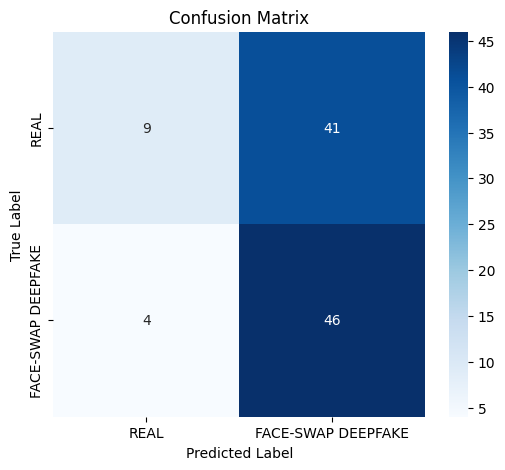


📊 Classification Report:
                    precision    recall  f1-score   support

              REAL       0.69      0.18      0.29        50
FACE-SWAP DEEPFAKE       0.53      0.92      0.67        50

          accuracy                           0.55       100
         macro avg       0.61      0.55      0.48       100
      weighted avg       0.61      0.55      0.48       100


📈 AUC Score: 0.5272


c:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\interpolate\_interpolate.py:701: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\interpolate\_interpolate.py:704: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


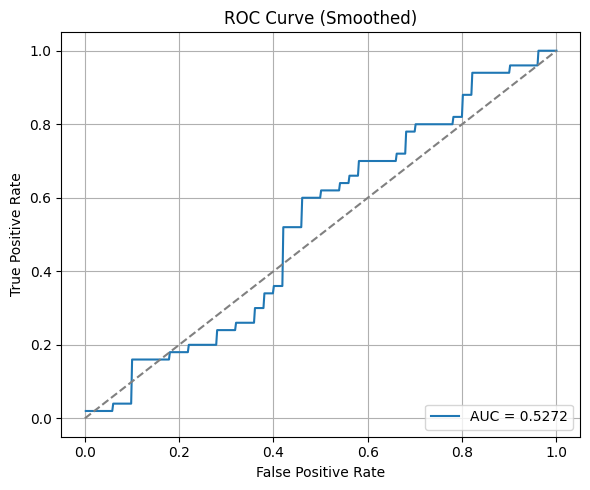

In [ ]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
from scipy.interpolate import interp1d


# Setup device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load model
def load_model(weights_path):
    model = DeepfakeClassifier()
    model.load_state_dict(torch.load(weights_path, map_location=device))
    model.to(device)
    model.eval()
    return model

# Path konfigurasi
model_path = "Model/AlexNet-BiLSTM_Wajah/AlexNet_256x256-BiLSTM_2_Wajah_2R1F.pth"
pt_folder = "Dataset_Skripsi/testing CNN-BiLSTM/Preprocessed_npy"
model = load_model(model_path)

classes = ['REAL', 'FACE-SWAP DEEPFAKE']
true_labels = []
predicted_labels = []
probs_class1 = []

# Loop seluruh file
for filename in sorted(os.listdir(pt_folder)):
    if not filename.endswith(".pt"):
        continue

    filepath = os.path.join(pt_folder, filename)
    data = torch.load(filepath)

    frames = torch.stack(data['frames']).unsqueeze(0).to(device)

    true_label = data['label'].item()

    with torch.no_grad():
        outputs = model(frames)
        probabilities = torch.softmax(outputs, dim=1).cpu().numpy()[0]
        predicted = int(np.argmax(probabilities))
        probs_class1.append(probabilities[1])

    print(f"{filename}: Predicted = {classes[predicted]}, True = {classes[true_label]}")

    true_labels.append(true_label)
    predicted_labels.append(predicted)

# Akurasi
total = len(true_labels)
correct = sum(p == t for p, t in zip(predicted_labels, true_labels))
accuracy = correct / total if total > 0 else 0
print(f"\n✅ Testing Accuracy: {accuracy * 100:.2f}% ({correct}/{total})")

# Confusion Matrix
cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print("\n📊 Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=classes))

# AUC Score
if len(set(true_labels)) == 2:
    auc_score = roc_auc_score(true_labels, probs_class1)
    print(f"\n📈 AUC Score: {auc_score:.4f}")

    # ROC Curve
    fpr, tpr, thresholds = roc_curve(true_labels, probs_class1)

    fpr_smooth = np.linspace(0, 1, 500)
    tpr_smooth = interp1d(fpr, tpr, kind='linear', fill_value="extrapolate")(fpr_smooth)

    # Plot
    plt.figure(figsize=(6, 5))
    plt.plot(fpr_smooth, tpr_smooth, label=f"AUC = {auc_score:.4f}")
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve (Smoothed)')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("\n⚠️ AUC tidak bisa dihitung karena hanya ada satu kelas di label.")

**Percobaan 3**

Full Conv Block (384, 256) -> ReLU

Weight Criterion 1:1

In [ ]:
import torch
import torch.nn as nn
from torchvision import models

# Model Fitur Ekstraktor
class AlexNetFeatureExtractor(nn.Module):
    def __init__(self):
        super(AlexNetFeatureExtractor, self).__init__()
        alexnet = models.alexnet(pretrained=True)
        for idx, layer in enumerate(alexnet.features.children()):
            for param in layer.parameters():
                param.requires_grad = False
        self.feature_extractor = nn.Sequential(*list(alexnet.features.children())[:-3])
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        

    def forward(self, x):
        B, T, C, H, W = x.shape
        x = x.view(B * T, C, H, W)       
        x = self.feature_extractor(x)       
        x = self.pool(x)                    
        x = x.view(B, T, -1)                
        return x

class AttentionLayer(nn.Module):
    def __init__(self, input_dim):
        super(AttentionLayer, self).__init__()
        self.attn = nn.Linear(input_dim, 1)

    def forward(self, x):
        weights = self.attn(x).squeeze(-1)
        weights = torch.softmax(weights, dim=1)
        attended = torch.sum(x * weights.unsqueeze(-1), dim=1)
        return attended

# Model Fitur Temporal
class BiLSTMDeepfake(nn.Module):
    def __init__(self, input_size=256, hidden_size=256, num_layers=2, dropout=0.3):
        super(BiLSTMDeepfake, self).__init__()
        self.lstm1 = nn.LSTM(input_size, hidden_size, num_layers=num_layers, batch_first=True,
                             bidirectional=True, dropout=dropout)
        self.lstm2 = nn.LSTM(hidden_size * 2, hidden_size, num_layers=num_layers, batch_first=True,
                             bidirectional=True, dropout=dropout)
        self.attention = AttentionLayer(hidden_size * 2)
        self.output_size = hidden_size * 2

    def forward(self, x):
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        attended = self.attention(x)
        return attended

# Model Gabungan Fitur
class DeepfakeClassifier(nn.Module):
    def __init__(self, num_classes=2):
        super(DeepfakeClassifier, self).__init__()
        self.visual_extractor = AlexNetFeatureExtractor()
        self.bilstm = BiLSTMDeepfake()
        
        input_dim = self.bilstm.output_size
        
        self.classifier = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.LayerNorm(256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.LayerNorm(128),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(128, num_classes)
        )

    def forward(self, frames):
        visual_feat_seq = self.visual_extractor(frames)
        visual_embed = self.bilstm(visual_feat_seq)
        out = self.classifier(visual_embed)
        return out

In [37]:
import torch
import torch.nn as nn

# Inisialisasi perangkat dan model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DeepfakeClassifier().to(device)

# Optimizer dan loss function
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
weights = torch.tensor([1.0, 1.0], device=device)  # bobot kelas REAL, DEEPFAKE
criterion = nn.CrossEntropyLoss(weight=weights)

In [33]:
model.eval()

DeepfakeClassifier(
  (visual_extractor): AlexNetFeatureExtractor(
    (feature_extractor): Sequential(
      (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (4): ReLU(inplace=True)
      (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace=True)
      (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU(inplace=True)
      (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (pool): AdaptiveAvgPool2d(output_size=(1, 1))
  )
  (bilstm): BiLSTMDeepfake(
    (lstm1): LSTM(256, 256, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)
    (lstm2): LSTM(512, 256, n

In [ ]:
# Log
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

num_epochs = 40
best_val_loss = float('inf')

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    total_correct = 0
    total_samples = 0

    # Training
    for frames, labels in train_loader:
        frames = torch.stack(frames).to(device) if isinstance(frames, list) else frames.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(frames)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * frames.size(0)
        _, predicted = torch.max(outputs, 1)
        total_correct += (predicted == labels).sum().item()
        total_samples += labels.size(0)

    train_acc = total_correct / total_samples
    train_loss = running_loss / total_samples

    # Validasi
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for frames, labels in val_loader:
            frames = torch.stack(frames).to(device) if isinstance(frames, list) else frames.to(device)
            labels = labels.to(device)

            outputs = model(frames)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * frames.size(0)
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    val_acc = val_correct / val_total
    val_loss = val_loss / val_total

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    
    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'Model/AlexNet-BiLSTM_Wajah/AlexNet_384x256-BiLSTM_2_Wajah_1R1F.pth')
    
    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} "
          f"| Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

Epoch [1/40] Train Loss: 0.7374 | Train Acc: 0.4813 | Val Loss: 0.6899 | Val Acc: 0.5224
Epoch [2/40] Train Loss: 0.7112 | Train Acc: 0.4813 | Val Loss: 0.6746 | Val Acc: 0.5970
Epoch [3/40] Train Loss: 0.6859 | Train Acc: 0.5560 | Val Loss: 0.7622 | Val Acc: 0.5224
Epoch [4/40] Train Loss: 0.6696 | Train Acc: 0.6231 | Val Loss: 0.6803 | Val Acc: 0.5821
Epoch [5/40] Train Loss: 0.6483 | Train Acc: 0.6418 | Val Loss: 0.7031 | Val Acc: 0.5672
Epoch [6/40] Train Loss: 0.6721 | Train Acc: 0.6231 | Val Loss: 0.5881 | Val Acc: 0.6567
Epoch [7/40] Train Loss: 0.6012 | Train Acc: 0.6828 | Val Loss: 0.5640 | Val Acc: 0.7164
Epoch [8/40] Train Loss: 0.5849 | Train Acc: 0.6940 | Val Loss: 0.7108 | Val Acc: 0.5672
Epoch [9/40] Train Loss: 0.6742 | Train Acc: 0.5560 | Val Loss: 0.6585 | Val Acc: 0.7015
Epoch [10/40] Train Loss: 0.6157 | Train Acc: 0.6903 | Val Loss: 0.7453 | Val Acc: 0.4627
Epoch [11/40] Train Loss: 0.5846 | Train Acc: 0.6940 | Val Loss: 0.5741 | Val Acc: 0.7015
Epoch [12/40] Train

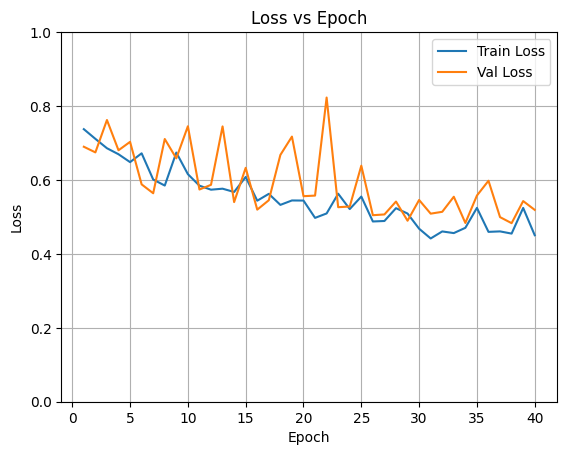

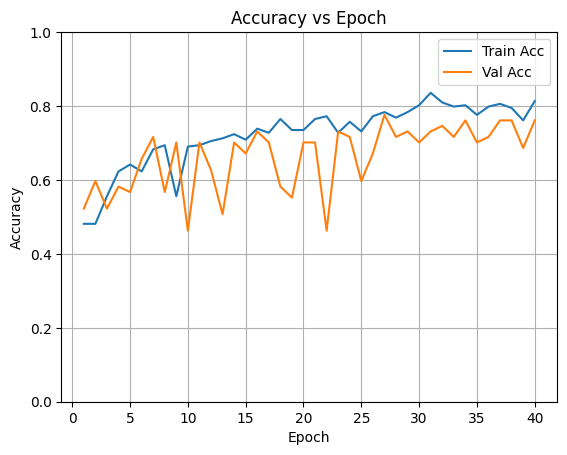

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, num_epochs + 1)

# Loss plot
plt.figure()
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.ylim(0, 1)  # Membatasi sumbu y dari 0 sampai 1
plt.legend()
plt.grid(True)
plt.show()

# Akurasi plot
plt.figure()
plt.plot(epochs, train_accuracies, label='Train Acc')
plt.plot(epochs, val_accuracies, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epoch')
plt.ylim(0, 1)  # Membatasi sumbu y dari 0 sampai 1
plt.legend()
plt.grid(True)
plt.show()

c:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


aabyjxwqyo.pt: Predicted = REAL, True = FACE-SWAP DEEPFAKE
aaeflzzhvy.pt: Predicted = REAL, True = FACE-SWAP DEEPFAKE
accfrqkrni.pt: Predicted = FACE-SWAP DEEPFAKE, True = FACE-SWAP DEEPFAKE
adfzvplbky.pt: Predicted = FACE-SWAP DEEPFAKE, True = FACE-SWAP DEEPFAKE
adrqlckutl.pt: Predicted = FACE-SWAP DEEPFAKE, True = FACE-SWAP DEEPFAKE
adsxwxeibr.pt: Predicted = FACE-SWAP DEEPFAKE, True = FACE-SWAP DEEPFAKE
ahencqpiin.pt: Predicted = FACE-SWAP DEEPFAKE, True = FACE-SWAP DEEPFAKE
alzbizkswy.pt: Predicted = FACE-SWAP DEEPFAKE, True = REAL
aqhbszcpal.pt: Predicted = REAL, True = FACE-SWAP DEEPFAKE
baqledjaon.pt: Predicted = FACE-SWAP DEEPFAKE, True = FACE-SWAP DEEPFAKE
barbcborgl.pt: Predicted = REAL, True = REAL
bfkzrgovsv.pt: Predicted = FACE-SWAP DEEPFAKE, True = REAL
bfljjbavig.pt: Predicted = FACE-SWAP DEEPFAKE, True = FACE-SWAP DEEPFAKE
bhqcqwcise.pt: Predicted = FACE-SWAP DEEPFAKE, True = REAL
bqwwkjlmgv.pt: Predicted = FACE-SWAP DEEPFAKE, True = FACE-SWAP DEEPFAKE
chjatzdqcl.pt: Pr

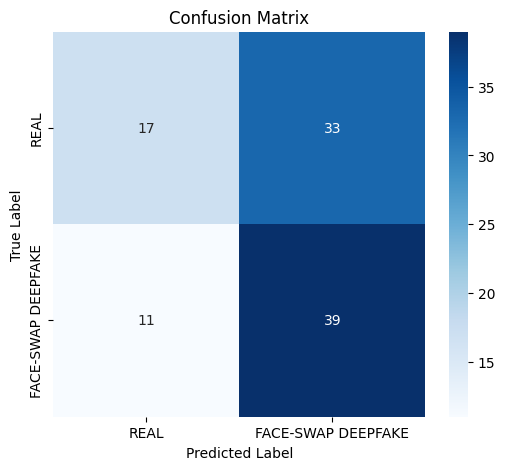


📊 Classification Report:
                    precision    recall  f1-score   support

              REAL       0.61      0.34      0.44        50
FACE-SWAP DEEPFAKE       0.54      0.78      0.64        50

          accuracy                           0.56       100
         macro avg       0.57      0.56      0.54       100
      weighted avg       0.57      0.56      0.54       100


📈 AUC Score: 0.5864


c:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\interpolate\_interpolate.py:701: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\interpolate\_interpolate.py:704: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


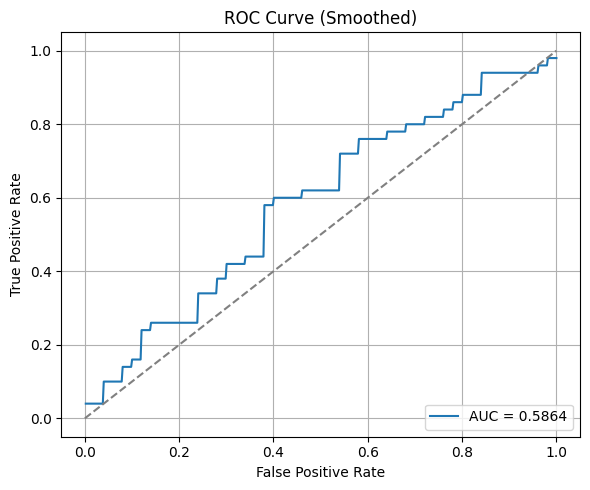

In [ ]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
from scipy.interpolate import interp1d


# Setup device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load model
def load_model(weights_path):
    model = DeepfakeClassifier()
    model.load_state_dict(torch.load(weights_path, map_location=device))
    model.to(device)
    model.eval()
    return model

# Path konfigurasi
model_path = "Model/AlexNet-BiLSTM_Wajah/AlexNet_384x256-BiLSTM_2_Wajah_1R1F.pth"
pt_folder = "Dataset_Skripsi/testing CNN-BiLSTM/Preprocessed_npy"
model = load_model(model_path)

classes = ['REAL', 'FACE-SWAP DEEPFAKE']
true_labels = []
predicted_labels = []
probs_class1 = []

# Loop seluruh file
for filename in sorted(os.listdir(pt_folder)):
    if not filename.endswith(".pt"):
        continue

    filepath = os.path.join(pt_folder, filename)
    data = torch.load(filepath)

    frames = torch.stack(data['frames']).unsqueeze(0).to(device)

    true_label = data['label'].item()

    with torch.no_grad():
        outputs = model(frames)
        probabilities = torch.softmax(outputs, dim=1).cpu().numpy()[0]
        predicted = int(np.argmax(probabilities))
        probs_class1.append(probabilities[1])

    print(f"{filename}: Predicted = {classes[predicted]}, True = {classes[true_label]}")

    true_labels.append(true_label)
    predicted_labels.append(predicted)

# Akurasi
total = len(true_labels)
correct = sum(p == t for p, t in zip(predicted_labels, true_labels))
accuracy = correct / total if total > 0 else 0
print(f"\n✅ Testing Accuracy: {accuracy * 100:.2f}% ({correct}/{total})")

# Confusion Matrix
cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print("\n📊 Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=classes))

# AUC Score
if len(set(true_labels)) == 2:
    auc_score = roc_auc_score(true_labels, probs_class1)
    print(f"\n📈 AUC Score: {auc_score:.4f}")

    # ROC Curve
    fpr, tpr, thresholds = roc_curve(true_labels, probs_class1)

    fpr_smooth = np.linspace(0, 1, 500)
    tpr_smooth = interp1d(fpr, tpr, kind='linear', fill_value="extrapolate")(fpr_smooth)

    # Plot
    plt.figure(figsize=(6, 5))
    plt.plot(fpr_smooth, tpr_smooth, label=f"AUC = {auc_score:.4f}")
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve (Smoothed)')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("\n⚠️ AUC tidak bisa dihitung karena hanya ada satu kelas di label.")

**Percobaan 4**

Full Conv Block (384, 256) -> ReLU

Weight Criterion 2:1

In [44]:
import torch
import torch.nn as nn

# Inisialisasi perangkat dan model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DeepfakeClassifier().to(device)

# Optimizer dan loss function
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
weights = torch.tensor([2.0, 1.0], device=device)  # bobot kelas REAL, DEEPFAKE
criterion = nn.CrossEntropyLoss(weight=weights)

c:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# Log
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

num_epochs = 40
best_val_loss = float('inf')

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    total_correct = 0
    total_samples = 0

    # Training
    for frames, labels in train_loader:
        frames = torch.stack(frames).to(device) if isinstance(frames, list) else frames.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(frames)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * frames.size(0)
        _, predicted = torch.max(outputs, 1)
        total_correct += (predicted == labels).sum().item()
        total_samples += labels.size(0)

    train_acc = total_correct / total_samples
    train_loss = running_loss / total_samples

    # Validasi
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for frames, labels in val_loader:
            frames = torch.stack(frames).to(device) if isinstance(frames, list) else frames.to(device)
            labels = labels.to(device)

            outputs = model(frames)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * frames.size(0)
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    val_acc = val_correct / val_total
    val_loss = val_loss / val_total

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    
    # Save model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'Model/AlexNet-BiLSTM_Wajah/AlexNet_384x256-BiLSTM_2_Wajah_2R1F.pth')
    
    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} "
          f"| Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

Epoch [1/40] Train Loss: 0.6762 | Train Acc: 0.5410 | Val Loss: 0.7080 | Val Acc: 0.4328
Epoch [2/40] Train Loss: 0.6375 | Train Acc: 0.5560 | Val Loss: 0.7256 | Val Acc: 0.4328
Epoch [3/40] Train Loss: 0.6382 | Train Acc: 0.5746 | Val Loss: 0.6785 | Val Acc: 0.4776
Epoch [4/40] Train Loss: 0.6108 | Train Acc: 0.5821 | Val Loss: 0.6787 | Val Acc: 0.5373
Epoch [5/40] Train Loss: 0.6039 | Train Acc: 0.6045 | Val Loss: 0.6990 | Val Acc: 0.4478
Epoch [6/40] Train Loss: 0.6048 | Train Acc: 0.6530 | Val Loss: 0.7926 | Val Acc: 0.4478
Epoch [7/40] Train Loss: 0.6079 | Train Acc: 0.6418 | Val Loss: 0.6175 | Val Acc: 0.6119
Epoch [8/40] Train Loss: 0.5743 | Train Acc: 0.6604 | Val Loss: 0.7016 | Val Acc: 0.4627
Epoch [9/40] Train Loss: 0.6026 | Train Acc: 0.6381 | Val Loss: 0.6793 | Val Acc: 0.4776
Epoch [10/40] Train Loss: 0.5480 | Train Acc: 0.7164 | Val Loss: 0.6770 | Val Acc: 0.5224
Epoch [11/40] Train Loss: 0.5220 | Train Acc: 0.6754 | Val Loss: 0.5265 | Val Acc: 0.7313
Epoch [12/40] Train

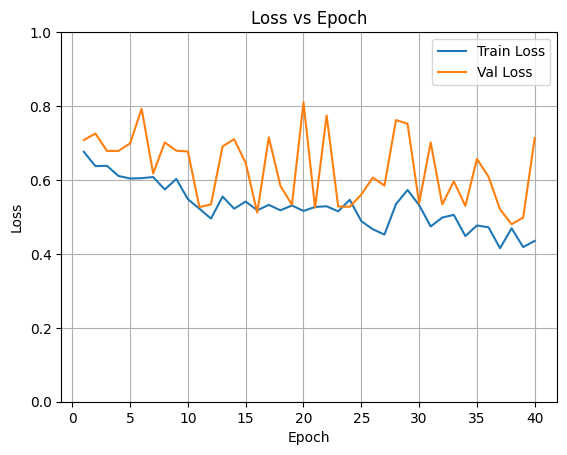

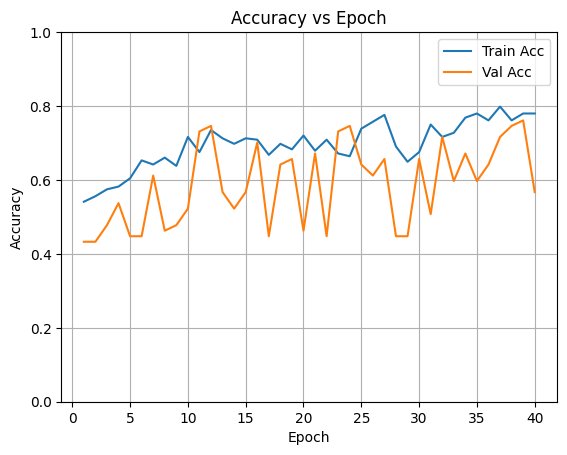

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, num_epochs + 1)

# Loss plot
plt.figure()
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.ylim(0, 1)  # Membatasi sumbu y dari 0 sampai 1
plt.legend()
plt.grid(True)
plt.show()

# Akurasi plot
plt.figure()
plt.plot(epochs, train_accuracies, label='Train Acc')
plt.plot(epochs, val_accuracies, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epoch')
plt.ylim(0, 1)  # Membatasi sumbu y dari 0 sampai 1
plt.legend()
plt.grid(True)
plt.show()

aabyjxwqyo.pt: Predicted = REAL, True = FACE-SWAP DEEPFAKE
aaeflzzhvy.pt: Predicted = REAL, True = FACE-SWAP DEEPFAKE
accfrqkrni.pt: Predicted = FACE-SWAP DEEPFAKE, True = FACE-SWAP DEEPFAKE
adfzvplbky.pt: Predicted = FACE-SWAP DEEPFAKE, True = FACE-SWAP DEEPFAKE
adrqlckutl.pt: Predicted = FACE-SWAP DEEPFAKE, True = FACE-SWAP DEEPFAKE
adsxwxeibr.pt: Predicted = FACE-SWAP DEEPFAKE, True = FACE-SWAP DEEPFAKE
ahencqpiin.pt: Predicted = FACE-SWAP DEEPFAKE, True = FACE-SWAP DEEPFAKE
alzbizkswy.pt: Predicted = FACE-SWAP DEEPFAKE, True = REAL
aqhbszcpal.pt: Predicted = FACE-SWAP DEEPFAKE, True = FACE-SWAP DEEPFAKE
baqledjaon.pt: Predicted = FACE-SWAP DEEPFAKE, True = FACE-SWAP DEEPFAKE
barbcborgl.pt: Predicted = FACE-SWAP DEEPFAKE, True = REAL
bfkzrgovsv.pt: Predicted = FACE-SWAP DEEPFAKE, True = REAL
bfljjbavig.pt: Predicted = REAL, True = FACE-SWAP DEEPFAKE
bhqcqwcise.pt: Predicted = FACE-SWAP DEEPFAKE, True = REAL
bqwwkjlmgv.pt: Predicted = FACE-SWAP DEEPFAKE, True = FACE-SWAP DEEPFAKE
chj

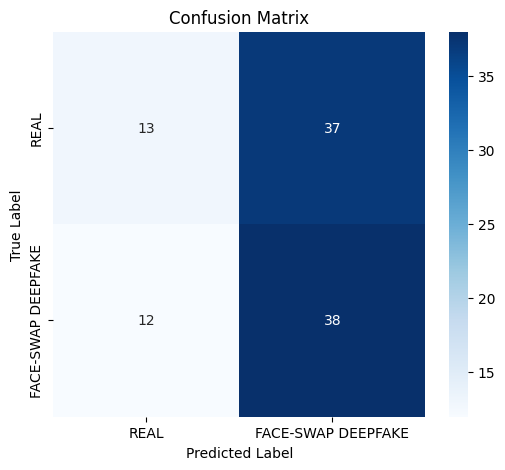


📊 Classification Report:
                    precision    recall  f1-score   support

              REAL       0.52      0.26      0.35        50
FACE-SWAP DEEPFAKE       0.51      0.76      0.61        50

          accuracy                           0.51       100
         macro avg       0.51      0.51      0.48       100
      weighted avg       0.51      0.51      0.48       100


📈 AUC Score: 0.5696


c:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\interpolate\_interpolate.py:701: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\interpolate\_interpolate.py:704: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


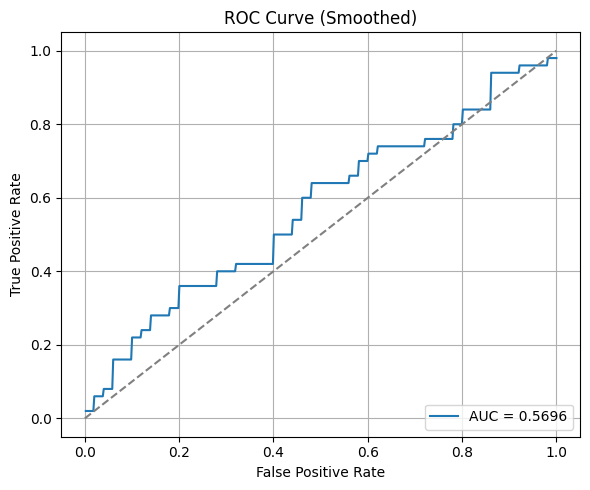

In [ ]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
from scipy.interpolate import interp1d


# Setup device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load model
def load_model(weights_path):
    model = DeepfakeClassifier()
    model.load_state_dict(torch.load(weights_path, map_location=device))
    model.to(device)
    model.eval()
    return model

# Path konfigurasi
model_path = "Model/AlexNet-BiLSTM_Wajah/AlexNet_384x256-BiLSTM_2_Wajah_2R1F.pth"
pt_folder = "Dataset_Skripsi/testing CNN-BiLSTM/Preprocessed_npy"
model = load_model(model_path)

classes = ['REAL', 'FACE-SWAP DEEPFAKE']
true_labels = []
predicted_labels = []
probs_class1 = []

# Loop seluruh file
for filename in sorted(os.listdir(pt_folder)):
    if not filename.endswith(".pt"):
        continue

    filepath = os.path.join(pt_folder, filename)
    data = torch.load(filepath)

    frames = torch.stack(data['frames']).unsqueeze(0).to(device)

    true_label = data['label'].item()

    with torch.no_grad():
        outputs = model(frames)
        probabilities = torch.softmax(outputs, dim=1).cpu().numpy()[0]
        predicted = int(np.argmax(probabilities))
        probs_class1.append(probabilities[1])

    print(f"{filename}: Predicted = {classes[predicted]}, True = {classes[true_label]}")

    true_labels.append(true_label)
    predicted_labels.append(predicted)

# Akurasi
total = len(true_labels)
correct = sum(p == t for p, t in zip(predicted_labels, true_labels))
accuracy = correct / total if total > 0 else 0
print(f"\n✅ Testing Accuracy: {accuracy * 100:.2f}% ({correct}/{total})")

# Confusion Matrix
cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print("\n📊 Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=classes))

# AUC Score
if len(set(true_labels)) == 2:
    auc_score = roc_auc_score(true_labels, probs_class1)
    print(f"\n📈 AUC Score: {auc_score:.4f}")

    # ROC Curve
    fpr, tpr, thresholds = roc_curve(true_labels, probs_class1)

    fpr_smooth = np.linspace(0, 1, 500)
    tpr_smooth = interp1d(fpr, tpr, kind='linear', fill_value="extrapolate")(fpr_smooth)

    # Plot
    plt.figure(figsize=(6, 5))
    plt.plot(fpr_smooth, tpr_smooth, label=f"AUC = {auc_score:.4f}")
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve (Smoothed)')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("\n⚠️ AUC tidak bisa dihitung karena hanya ada satu kelas di label.")

**Percobaan 5**

Full Conv Block (192, 384) -> ReLU

Weight Criterion 1:1

In [ ]:
import torch
import torch.nn as nn
from torchvision import models

# Model Fitur Ekstraktor
class AlexNetFeatureExtractor(nn.Module):
    def __init__(self):
        super(AlexNetFeatureExtractor, self).__init__()
        alexnet = models.alexnet(pretrained=True)
        for idx, layer in enumerate(alexnet.features.children()):
            for param in layer.parameters():
                param.requires_grad = False
        self.feature_extractor = nn.Sequential(*list(alexnet.features.children())[:-5])
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        

    def forward(self, x):
        B, T, C, H, W = x.shape
        x = x.view(B * T, C, H, W)       
        x = self.feature_extractor(x)       
        x = self.pool(x)                    
        x = x.view(B, T, -1)                
        return x

class AttentionLayer(nn.Module):
    def __init__(self, input_dim):
        super(AttentionLayer, self).__init__()
        self.attn = nn.Linear(input_dim, 1)

    def forward(self, x):
        weights = self.attn(x).squeeze(-1)
        weights = torch.softmax(weights, dim=1)
        attended = torch.sum(x * weights.unsqueeze(-1), dim=1)
        return attended

# Model Fitur Temporal
class BiLSTMDeepfake(nn.Module):
    def __init__(self, input_size=384, hidden_size=256, num_layers=2, dropout=0.3):
        super(BiLSTMDeepfake, self).__init__()
        self.lstm1 = nn.LSTM(input_size, hidden_size, num_layers=num_layers, batch_first=True,
                             bidirectional=True, dropout=dropout)
        self.lstm2 = nn.LSTM(hidden_size * 2, hidden_size, num_layers=num_layers, batch_first=True,
                             bidirectional=True, dropout=dropout)
        self.attention = AttentionLayer(hidden_size * 2)
        self.output_size = hidden_size * 2

    def forward(self, x):
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        attended = self.attention(x)  # (B, 2H)
        return attended

# Model Gabungan Fitur
class DeepfakeClassifier(nn.Module):
    def __init__(self, num_classes=2):
        super(DeepfakeClassifier, self).__init__()
        self.visual_extractor = AlexNetFeatureExtractor()
        self.bilstm = BiLSTMDeepfake()
        
        input_dim = self.bilstm.output_size
        
        self.classifier = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.LayerNorm(256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.LayerNorm(128),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(128, num_classes)
        )

    def forward(self, frames):
        visual_feat_seq = self.visual_extractor(frames)
        visual_embed = self.bilstm(visual_feat_seq)
        out = self.classifier(visual_embed)
        return out

In [51]:
import torch
import torch.nn as nn

# Inisialisasi perangkat dan model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DeepfakeClassifier().to(device)

# Optimizer dan loss function
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
weights = torch.tensor([1.0, 1.0], device=device)  # bobot kelas REAL, DEEPFAKE
criterion = nn.CrossEntropyLoss(weight=weights)

c:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [53]:
model.eval()

DeepfakeClassifier(
  (visual_extractor): AlexNetFeatureExtractor(
    (feature_extractor): Sequential(
      (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (4): ReLU(inplace=True)
      (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace=True)
    )
    (pool): AdaptiveAvgPool2d(output_size=(1, 1))
  )
  (bilstm): BiLSTMDeepfake(
    (lstm1): LSTM(384, 256, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)
    (lstm2): LSTM(512, 256, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)
    (attention): AttentionLayer(
      (attn): Linear(in_features=512, out_features=1, bias=True)
    )
  )
  (classifier): S

In [ ]:
# Log
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

num_epochs = 40
best_val_loss = float('inf')

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    total_correct = 0
    total_samples = 0

    # Training
    for frames, labels in train_loader:
        frames = torch.stack(frames).to(device) if isinstance(frames, list) else frames.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(frames)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * frames.size(0)
        _, predicted = torch.max(outputs, 1)
        total_correct += (predicted == labels).sum().item()
        total_samples += labels.size(0)

    train_acc = total_correct / total_samples
    train_loss = running_loss / total_samples

    # Validasi
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for frames, labels in val_loader:
            frames = torch.stack(frames).to(device) if isinstance(frames, list) else frames.to(device)
            labels = labels.to(device)

            outputs = model(frames)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * frames.size(0)
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    val_acc = val_correct / val_total
    val_loss = val_loss / val_total

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    
    # Save model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'Model/AlexNet-BiLSTM_Wajah/AlexNet_192x384-BiLSTM_2_Wajah_1R1F.pth')
    
    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} "
          f"| Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

Epoch [1/40] Train Loss: 0.7388 | Train Acc: 0.4776 | Val Loss: 0.7509 | Val Acc: 0.4328
Epoch [2/40] Train Loss: 0.7221 | Train Acc: 0.4888 | Val Loss: 0.6742 | Val Acc: 0.5672
Epoch [3/40] Train Loss: 0.6920 | Train Acc: 0.5187 | Val Loss: 0.6587 | Val Acc: 0.6269
Epoch [4/40] Train Loss: 0.7057 | Train Acc: 0.5560 | Val Loss: 0.6825 | Val Acc: 0.5970
Epoch [5/40] Train Loss: 0.6454 | Train Acc: 0.6269 | Val Loss: 0.6298 | Val Acc: 0.6418
Epoch [6/40] Train Loss: 0.6628 | Train Acc: 0.6343 | Val Loss: 0.7051 | Val Acc: 0.5672
Epoch [7/40] Train Loss: 0.6206 | Train Acc: 0.6679 | Val Loss: 0.6398 | Val Acc: 0.6269
Epoch [8/40] Train Loss: 0.6406 | Train Acc: 0.6530 | Val Loss: 0.8323 | Val Acc: 0.4478
Epoch [9/40] Train Loss: 0.6231 | Train Acc: 0.6455 | Val Loss: 0.6027 | Val Acc: 0.7313
Epoch [10/40] Train Loss: 0.6169 | Train Acc: 0.6754 | Val Loss: 0.6199 | Val Acc: 0.6866
Epoch [11/40] Train Loss: 0.5716 | Train Acc: 0.7127 | Val Loss: 0.5341 | Val Acc: 0.7313
Epoch [12/40] Train

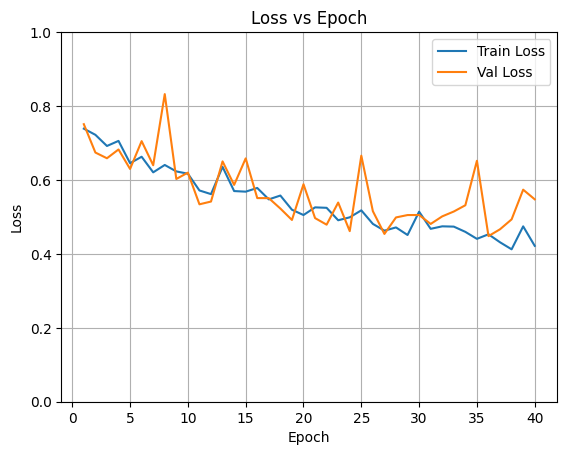

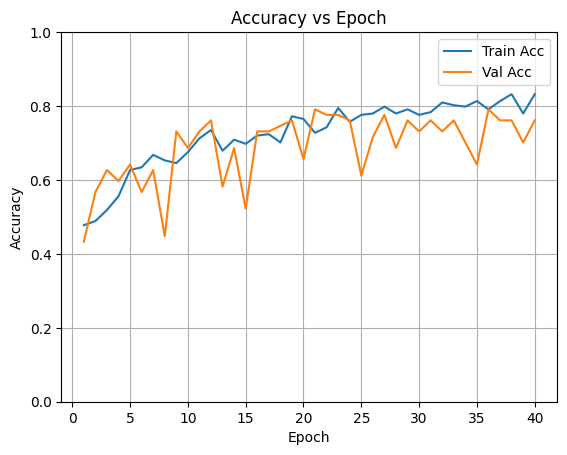

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, num_epochs + 1)

# Loss plot
plt.figure()
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.ylim(0, 1)  # Membatasi sumbu y dari 0 sampai 1
plt.legend()
plt.grid(True)
plt.show()

# Akurasi plot
plt.figure()
plt.plot(epochs, train_accuracies, label='Train Acc')
plt.plot(epochs, val_accuracies, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epoch')
plt.ylim(0, 1)  # Membatasi sumbu y dari 0 sampai 1
plt.legend()
plt.grid(True)
plt.show()

c:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


aabyjxwqyo.pt: Predicted = FACE-SWAP DEEPFAKE, True = FACE-SWAP DEEPFAKE
aaeflzzhvy.pt: Predicted = FACE-SWAP DEEPFAKE, True = FACE-SWAP DEEPFAKE
accfrqkrni.pt: Predicted = FACE-SWAP DEEPFAKE, True = FACE-SWAP DEEPFAKE
adfzvplbky.pt: Predicted = FACE-SWAP DEEPFAKE, True = FACE-SWAP DEEPFAKE
adrqlckutl.pt: Predicted = FACE-SWAP DEEPFAKE, True = FACE-SWAP DEEPFAKE
adsxwxeibr.pt: Predicted = FACE-SWAP DEEPFAKE, True = FACE-SWAP DEEPFAKE
ahencqpiin.pt: Predicted = FACE-SWAP DEEPFAKE, True = FACE-SWAP DEEPFAKE
alzbizkswy.pt: Predicted = FACE-SWAP DEEPFAKE, True = REAL
aqhbszcpal.pt: Predicted = REAL, True = FACE-SWAP DEEPFAKE
baqledjaon.pt: Predicted = FACE-SWAP DEEPFAKE, True = FACE-SWAP DEEPFAKE
barbcborgl.pt: Predicted = FACE-SWAP DEEPFAKE, True = REAL
bfkzrgovsv.pt: Predicted = FACE-SWAP DEEPFAKE, True = REAL
bfljjbavig.pt: Predicted = FACE-SWAP DEEPFAKE, True = FACE-SWAP DEEPFAKE
bhqcqwcise.pt: Predicted = FACE-SWAP DEEPFAKE, True = REAL
bqwwkjlmgv.pt: Predicted = FACE-SWAP DEEPFAKE, T

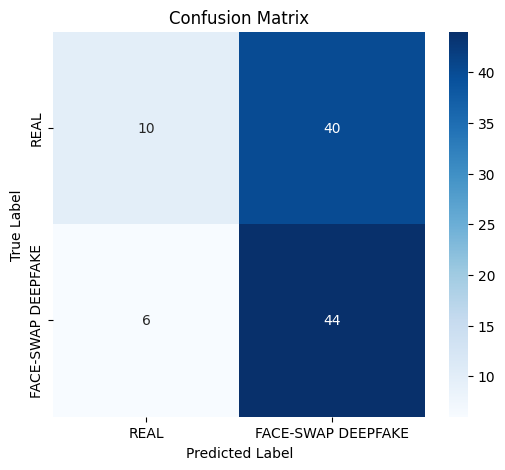


📊 Classification Report:
                    precision    recall  f1-score   support

              REAL       0.62      0.20      0.30        50
FACE-SWAP DEEPFAKE       0.52      0.88      0.66        50

          accuracy                           0.54       100
         macro avg       0.57      0.54      0.48       100
      weighted avg       0.57      0.54      0.48       100


📈 AUC Score: 0.5898


c:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\interpolate\_interpolate.py:701: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\interpolate\_interpolate.py:704: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


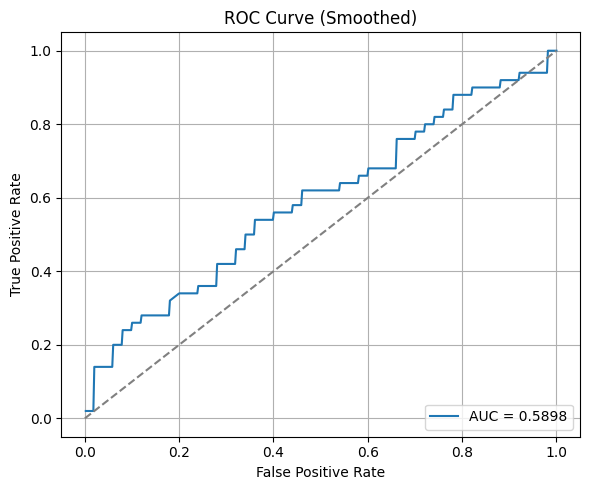

In [ ]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
from scipy.interpolate import interp1d


# Setup device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load model
def load_model(weights_path):
    model = DeepfakeClassifier()
    model.load_state_dict(torch.load(weights_path, map_location=device))
    model.to(device)
    model.eval()
    return model

# Path konfigurasi
model_path = "Model/AlexNet-BiLSTM_Wajah/AlexNet_192x384-BiLSTM_2_Wajah_1R1F.pth"
pt_folder = "Dataset_Skripsi/testing CNN-BiLSTM/Preprocessed_npy"
model = load_model(model_path)

classes = ['REAL', 'FACE-SWAP DEEPFAKE']
true_labels = []
predicted_labels = []
probs_class1 = []

# Loop seluruh file
for filename in sorted(os.listdir(pt_folder)):
    if not filename.endswith(".pt"):
        continue

    filepath = os.path.join(pt_folder, filename)
    data = torch.load(filepath)

    frames = torch.stack(data['frames']).unsqueeze(0).to(device)

    true_label = data['label'].item()

    with torch.no_grad():
        outputs = model(frames)
        probabilities = torch.softmax(outputs, dim=1).cpu().numpy()[0]
        predicted = int(np.argmax(probabilities))
        probs_class1.append(probabilities[1])

    print(f"{filename}: Predicted = {classes[predicted]}, True = {classes[true_label]}")

    true_labels.append(true_label)
    predicted_labels.append(predicted)

# Akurasi
total = len(true_labels)
correct = sum(p == t for p, t in zip(predicted_labels, true_labels))
accuracy = correct / total if total > 0 else 0
print(f"\n✅ Testing Accuracy: {accuracy * 100:.2f}% ({correct}/{total})")

# Confusion Matrix
cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print("\n📊 Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=classes))

# AUC Score
if len(set(true_labels)) == 2:
    auc_score = roc_auc_score(true_labels, probs_class1)
    print(f"\n📈 AUC Score: {auc_score:.4f}")

    # ROC Curve
    fpr, tpr, thresholds = roc_curve(true_labels, probs_class1)

    fpr_smooth = np.linspace(0, 1, 500)
    tpr_smooth = interp1d(fpr, tpr, kind='linear', fill_value="extrapolate")(fpr_smooth)

    # Plot
    plt.figure(figsize=(6, 5))
    plt.plot(fpr_smooth, tpr_smooth, label=f"AUC = {auc_score:.4f}")
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve (Smoothed)')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("\n⚠️ AUC tidak bisa dihitung karena hanya ada satu kelas di label.")

**Percobaan 6**

Full Conv Block (192, 384) -> ReLU

Weight Criterion 2:1

In [59]:
import torch
import torch.nn as nn

# Inisialisasi perangkat dan model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DeepfakeClassifier().to(device)

# Optimizer dan loss function
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
weights = torch.tensor([2.0, 1.0], device=device)  # bobot kelas REAL, DEEPFAKE
criterion = nn.CrossEntropyLoss(weight=weights)

c:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# Log
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

num_epochs = 40
best_val_loss = float('inf')

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    total_correct = 0
    total_samples = 0

    # Training
    for frames, labels in train_loader:
        frames = torch.stack(frames).to(device) if isinstance(frames, list) else frames.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(frames)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * frames.size(0)
        _, predicted = torch.max(outputs, 1)
        total_correct += (predicted == labels).sum().item()
        total_samples += labels.size(0)

    train_acc = total_correct / total_samples
    train_loss = running_loss / total_samples

    # Validasi
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for frames, labels in val_loader:
            frames = torch.stack(frames).to(device) if isinstance(frames, list) else frames.to(device)
            labels = labels.to(device)

            outputs = model(frames)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * frames.size(0)
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    val_acc = val_correct / val_total
    val_loss = val_loss / val_total

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    
    # Save model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'Model/AlexNet-BiLSTM_Wajah/AlexNet_192x384-BiLSTM_2_Wajah_2R1F.pth')
    
    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} "
          f"| Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

Epoch [1/40] Train Loss: 0.6860 | Train Acc: 0.5224 | Val Loss: 0.6835 | Val Acc: 0.4328
Epoch [2/40] Train Loss: 0.6575 | Train Acc: 0.5000 | Val Loss: 0.6882 | Val Acc: 0.4328
Epoch [3/40] Train Loss: 0.6776 | Train Acc: 0.5522 | Val Loss: 0.6571 | Val Acc: 0.6119
Epoch [4/40] Train Loss: 0.6333 | Train Acc: 0.5634 | Val Loss: 0.6366 | Val Acc: 0.5970
Epoch [5/40] Train Loss: 0.6284 | Train Acc: 0.5858 | Val Loss: 0.7144 | Val Acc: 0.4328
Epoch [6/40] Train Loss: 0.6218 | Train Acc: 0.5821 | Val Loss: 0.5984 | Val Acc: 0.5970
Epoch [7/40] Train Loss: 0.5877 | Train Acc: 0.6157 | Val Loss: 0.6362 | Val Acc: 0.5224
Epoch [8/40] Train Loss: 0.5755 | Train Acc: 0.6791 | Val Loss: 0.5771 | Val Acc: 0.6119
Epoch [9/40] Train Loss: 0.5274 | Train Acc: 0.6978 | Val Loss: 0.5455 | Val Acc: 0.7463
Epoch [10/40] Train Loss: 0.5677 | Train Acc: 0.6866 | Val Loss: 0.5095 | Val Acc: 0.7164
Epoch [11/40] Train Loss: 0.5916 | Train Acc: 0.6455 | Val Loss: 0.7048 | Val Acc: 0.4328
Epoch [12/40] Train

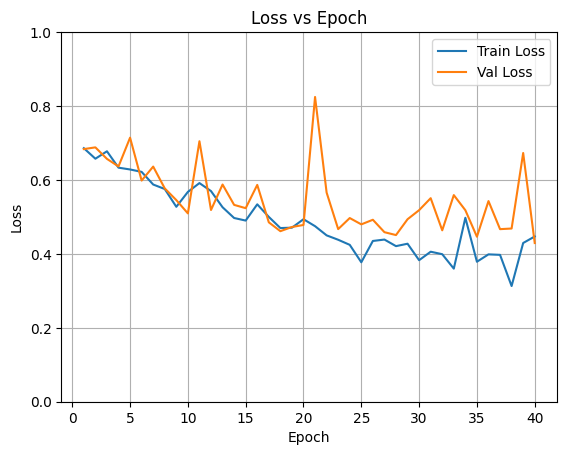

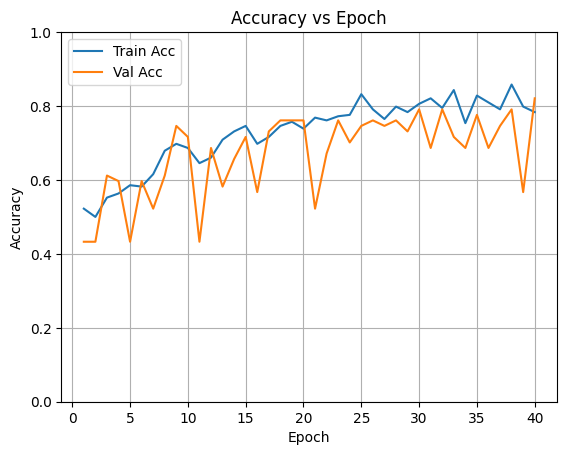

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, num_epochs + 1)

# Loss plot
plt.figure()
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.ylim(0, 1)  # Membatasi sumbu y dari 0 sampai 1
plt.legend()
plt.grid(True)
plt.show()

# Akurasi plot
plt.figure()
plt.plot(epochs, train_accuracies, label='Train Acc')
plt.plot(epochs, val_accuracies, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epoch')
plt.ylim(0, 1)  # Membatasi sumbu y dari 0 sampai 1
plt.legend()
plt.grid(True)
plt.show()

aabyjxwqyo.pt: Predicted = REAL, True = FACE-SWAP DEEPFAKE
aaeflzzhvy.pt: Predicted = FACE-SWAP DEEPFAKE, True = FACE-SWAP DEEPFAKE
accfrqkrni.pt: Predicted = FACE-SWAP DEEPFAKE, True = FACE-SWAP DEEPFAKE
adfzvplbky.pt: Predicted = FACE-SWAP DEEPFAKE, True = FACE-SWAP DEEPFAKE
adrqlckutl.pt: Predicted = FACE-SWAP DEEPFAKE, True = FACE-SWAP DEEPFAKE
adsxwxeibr.pt: Predicted = FACE-SWAP DEEPFAKE, True = FACE-SWAP DEEPFAKE
ahencqpiin.pt: Predicted = FACE-SWAP DEEPFAKE, True = FACE-SWAP DEEPFAKE
alzbizkswy.pt: Predicted = FACE-SWAP DEEPFAKE, True = REAL
aqhbszcpal.pt: Predicted = FACE-SWAP DEEPFAKE, True = FACE-SWAP DEEPFAKE
baqledjaon.pt: Predicted = FACE-SWAP DEEPFAKE, True = FACE-SWAP DEEPFAKE
barbcborgl.pt: Predicted = REAL, True = REAL
bfkzrgovsv.pt: Predicted = FACE-SWAP DEEPFAKE, True = REAL
bfljjbavig.pt: Predicted = FACE-SWAP DEEPFAKE, True = FACE-SWAP DEEPFAKE
bhqcqwcise.pt: Predicted = FACE-SWAP DEEPFAKE, True = REAL
bqwwkjlmgv.pt: Predicted = FACE-SWAP DEEPFAKE, True = FACE-SWA

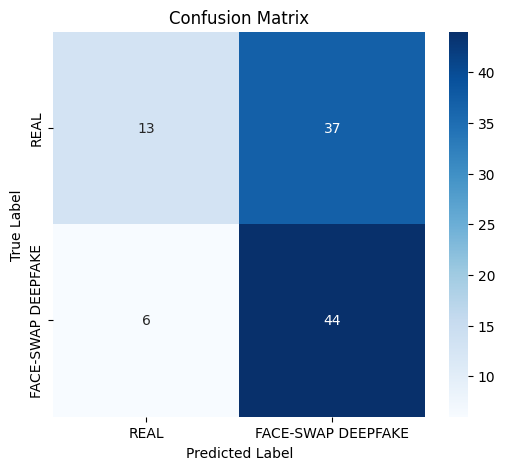


📊 Classification Report:
                    precision    recall  f1-score   support

              REAL       0.68      0.26      0.38        50
FACE-SWAP DEEPFAKE       0.54      0.88      0.67        50

          accuracy                           0.57       100
         macro avg       0.61      0.57      0.52       100
      weighted avg       0.61      0.57      0.52       100


📈 AUC Score: 0.5856


c:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\interpolate\_interpolate.py:701: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\interpolate\_interpolate.py:704: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


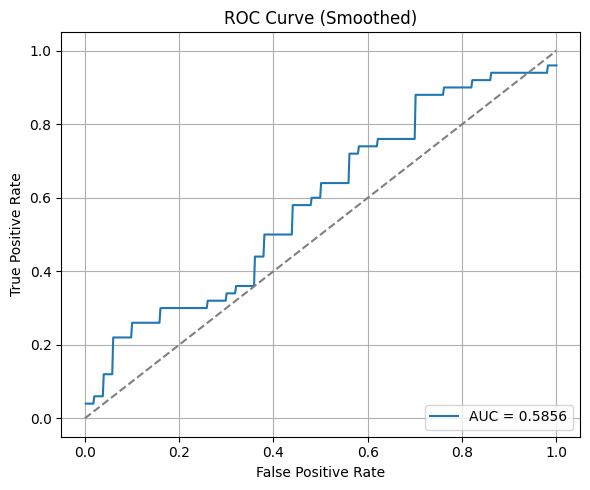

In [ ]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
from scipy.interpolate import interp1d


# Setup device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load model
def load_model(weights_path):
    model = DeepfakeClassifier()
    model.load_state_dict(torch.load(weights_path, map_location=device))
    model.to(device)
    model.eval()
    return model

# Path konfigurasi
model_path = "Model/AlexNet-BiLSTM_Wajah/AlexNet_192x384-BiLSTM_2_Wajah_2R1F.pth"
pt_folder = "Dataset_Skripsi/testing CNN-BiLSTM/Preprocessed_npy"
model = load_model(model_path)

classes = ['REAL', 'FACE-SWAP DEEPFAKE']
true_labels = []
predicted_labels = []
probs_class1 = []

# Loop seluruh file
for filename in sorted(os.listdir(pt_folder)):
    if not filename.endswith(".pt"):
        continue

    filepath = os.path.join(pt_folder, filename)
    data = torch.load(filepath)

    frames = torch.stack(data['frames']).unsqueeze(0).to(device)

    true_label = data['label'].item()

    with torch.no_grad():
        outputs = model(frames)
        probabilities = torch.softmax(outputs, dim=1).cpu().numpy()[0]
        predicted = int(np.argmax(probabilities))
        probs_class1.append(probabilities[1])

    print(f"{filename}: Predicted = {classes[predicted]}, True = {classes[true_label]}")

    true_labels.append(true_label)
    predicted_labels.append(predicted)

# Akurasi
total = len(true_labels)
correct = sum(p == t for p, t in zip(predicted_labels, true_labels))
accuracy = correct / total if total > 0 else 0
print(f"\n✅ Testing Accuracy: {accuracy * 100:.2f}% ({correct}/{total})")

# Confusion Matrix
cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print("\n📊 Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=classes))

# AUC Score
if len(set(true_labels)) == 2:
    auc_score = roc_auc_score(true_labels, probs_class1)
    print(f"\n📈 AUC Score: {auc_score:.4f}")

    # ROC Curve
    fpr, tpr, thresholds = roc_curve(true_labels, probs_class1)

    fpr_smooth = np.linspace(0, 1, 500)
    tpr_smooth = interp1d(fpr, tpr, kind='linear', fill_value="extrapolate")(fpr_smooth)

    # Plot
    plt.figure(figsize=(6, 5))
    plt.plot(fpr_smooth, tpr_smooth, label=f"AUC = {auc_score:.4f}")
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve (Smoothed)')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("\n⚠️ AUC tidak bisa dihitung karena hanya ada satu kelas di label.")

**Percobaan 7**

Full Conv Block (64, 192) -> ReLU

Weight Criterion 1:1

In [ ]:
import torch
import torch.nn as nn
from torchvision import models

# Model Fitur Ekstraktor
class AlexNetFeatureExtractor(nn.Module):
    def __init__(self):
        super(AlexNetFeatureExtractor, self).__init__()
        alexnet = models.alexnet(pretrained=True)
        for idx, layer in enumerate(alexnet.features.children()):
            for param in layer.parameters():
                param.requires_grad = False
        self.feature_extractor = nn.Sequential(*list(alexnet.features.children())[:-7])
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        

    def forward(self, x):
        B, T, C, H, W = x.shape
        x = x.view(B * T, C, H, W)       
        x = self.feature_extractor(x)       
        x = self.pool(x)                    
        x = x.view(B, T, -1)                
        return x

class AttentionLayer(nn.Module):
    def __init__(self, input_dim):
        super(AttentionLayer, self).__init__()
        self.attn = nn.Linear(input_dim, 1)

    def forward(self, x):
        weights = self.attn(x).squeeze(-1)
        weights = torch.softmax(weights, dim=1)
        attended = torch.sum(x * weights.unsqueeze(-1), dim=1)
        return attended

# Model Fitur Temporal
class BiLSTMDeepfake(nn.Module):
    def __init__(self, input_size=192, hidden_size=256, num_layers=2, dropout=0.3):
        super(BiLSTMDeepfake, self).__init__()
        self.lstm1 = nn.LSTM(input_size, hidden_size, num_layers=num_layers, batch_first=True,
                             bidirectional=True, dropout=dropout)
        self.lstm2 = nn.LSTM(hidden_size * 2, hidden_size, num_layers=num_layers, batch_first=True,
                             bidirectional=True, dropout=dropout)
        self.attention = AttentionLayer(hidden_size * 2)
        self.output_size = hidden_size * 2

    def forward(self, x):
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        attended = self.attention(x)
        return attended

# Model Gabungan Fitur
class DeepfakeClassifier(nn.Module):
    def __init__(self, num_classes=2):
        super(DeepfakeClassifier, self).__init__()
        self.visual_extractor = AlexNetFeatureExtractor()
        self.bilstm = BiLSTMDeepfake()
        
        input_dim = self.bilstm.output_size
        
        self.classifier = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.LayerNorm(256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.LayerNorm(128),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(128, num_classes)
        )

    def forward(self, frames):
        visual_feat_seq = self.visual_extractor(frames)
        visual_embed = self.bilstm(visual_feat_seq)
        out = self.classifier(visual_embed)
        return out

In [69]:
import torch
import torch.nn as nn

# Inisialisasi perangkat dan model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DeepfakeClassifier().to(device)

# Optimizer dan loss function
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
weights = torch.tensor([1.0, 1.0], device=device)  # bobot kelas REAL, DEEPFAKE
criterion = nn.CrossEntropyLoss(weight=weights)

c:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [70]:
model.eval()

DeepfakeClassifier(
  (visual_extractor): AlexNetFeatureExtractor(
    (feature_extractor): Sequential(
      (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (4): ReLU(inplace=True)
      (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (pool): AdaptiveAvgPool2d(output_size=(1, 1))
  )
  (bilstm): BiLSTMDeepfake(
    (lstm1): LSTM(192, 256, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)
    (lstm2): LSTM(512, 256, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)
    (attention): AttentionLayer(
      (attn): Linear(in_features=512, out_features=1, bias=True)
    )
  )
  (classifier): Sequential(
    (0): Linear(in_features=512, out_features=256, bias=True)
    (1): LayerNorm((256,), eps=1e-05

In [ ]:
# Log
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

num_epochs = 40
best_val_loss = float('inf')

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    total_correct = 0
    total_samples = 0

    # Training
    for frames, labels in train_loader:
        frames = torch.stack(frames).to(device) if isinstance(frames, list) else frames.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(frames)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * frames.size(0)
        _, predicted = torch.max(outputs, 1)
        total_correct += (predicted == labels).sum().item()
        total_samples += labels.size(0)

    train_acc = total_correct / total_samples
    train_loss = running_loss / total_samples

    # Validasi
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for frames, labels in val_loader:
            frames = torch.stack(frames).to(device) if isinstance(frames, list) else frames.to(device)
            labels = labels.to(device)

            outputs = model(frames)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * frames.size(0)
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    val_acc = val_correct / val_total
    val_loss = val_loss / val_total

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    
    # Save Model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'Model/AlexNet-BiLSTM_Wajah/AlexNet_64x192-BiLSTM_2_Wajah_1R1F.pth')
    
    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} "
          f"| Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

Epoch [1/40] Train Loss: 0.7329 | Train Acc: 0.4590 | Val Loss: 0.7116 | Val Acc: 0.4328
Epoch [2/40] Train Loss: 0.7005 | Train Acc: 0.5410 | Val Loss: 0.6814 | Val Acc: 0.6716
Epoch [3/40] Train Loss: 0.7136 | Train Acc: 0.5187 | Val Loss: 0.6752 | Val Acc: 0.6716
Epoch [4/40] Train Loss: 0.7016 | Train Acc: 0.5299 | Val Loss: 0.7235 | Val Acc: 0.4328
Epoch [5/40] Train Loss: 0.6904 | Train Acc: 0.5373 | Val Loss: 0.6639 | Val Acc: 0.6567
Epoch [6/40] Train Loss: 0.6865 | Train Acc: 0.5634 | Val Loss: 0.8234 | Val Acc: 0.4328
Epoch [7/40] Train Loss: 0.7014 | Train Acc: 0.5299 | Val Loss: 0.7022 | Val Acc: 0.4328
Epoch [8/40] Train Loss: 0.7106 | Train Acc: 0.4851 | Val Loss: 0.6896 | Val Acc: 0.5970
Epoch [9/40] Train Loss: 0.6959 | Train Acc: 0.5112 | Val Loss: 0.6909 | Val Acc: 0.5373
Epoch [10/40] Train Loss: 0.7064 | Train Acc: 0.5187 | Val Loss: 0.6681 | Val Acc: 0.5821
Epoch [11/40] Train Loss: 0.6790 | Train Acc: 0.5709 | Val Loss: 0.6777 | Val Acc: 0.5970
Epoch [12/40] Train

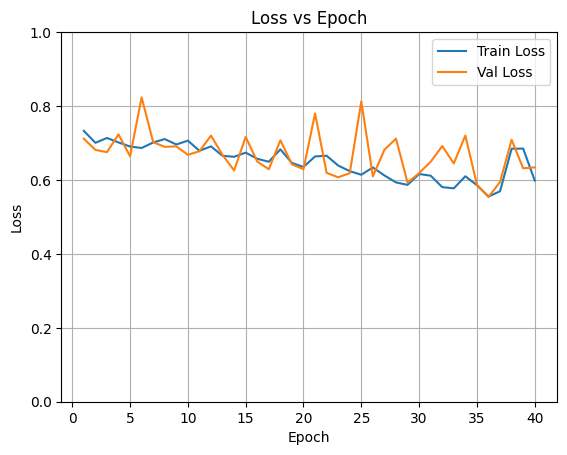

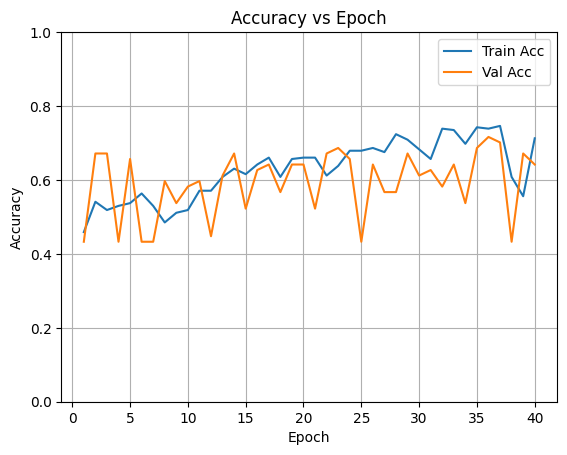

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, num_epochs + 1)

# Loss plot
plt.figure()
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.ylim(0, 1)  # Membatasi sumbu y dari 0 sampai 1
plt.legend()
plt.grid(True)
plt.show()

# Akurasi plot
plt.figure()
plt.plot(epochs, train_accuracies, label='Train Acc')
plt.plot(epochs, val_accuracies, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epoch')
plt.ylim(0, 1)  # Membatasi sumbu y dari 0 sampai 1
plt.legend()
plt.grid(True)
plt.show()

c:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


aabyjxwqyo.pt: Predicted = FACE-SWAP DEEPFAKE, True = FACE-SWAP DEEPFAKE
aaeflzzhvy.pt: Predicted = FACE-SWAP DEEPFAKE, True = FACE-SWAP DEEPFAKE
accfrqkrni.pt: Predicted = FACE-SWAP DEEPFAKE, True = FACE-SWAP DEEPFAKE
adfzvplbky.pt: Predicted = FACE-SWAP DEEPFAKE, True = FACE-SWAP DEEPFAKE
adrqlckutl.pt: Predicted = FACE-SWAP DEEPFAKE, True = FACE-SWAP DEEPFAKE
adsxwxeibr.pt: Predicted = FACE-SWAP DEEPFAKE, True = FACE-SWAP DEEPFAKE
ahencqpiin.pt: Predicted = FACE-SWAP DEEPFAKE, True = FACE-SWAP DEEPFAKE
alzbizkswy.pt: Predicted = FACE-SWAP DEEPFAKE, True = REAL
aqhbszcpal.pt: Predicted = FACE-SWAP DEEPFAKE, True = FACE-SWAP DEEPFAKE
baqledjaon.pt: Predicted = FACE-SWAP DEEPFAKE, True = FACE-SWAP DEEPFAKE
barbcborgl.pt: Predicted = FACE-SWAP DEEPFAKE, True = REAL
bfkzrgovsv.pt: Predicted = FACE-SWAP DEEPFAKE, True = REAL
bfljjbavig.pt: Predicted = FACE-SWAP DEEPFAKE, True = FACE-SWAP DEEPFAKE
bhqcqwcise.pt: Predicted = REAL, True = REAL
bqwwkjlmgv.pt: Predicted = FACE-SWAP DEEPFAKE, T

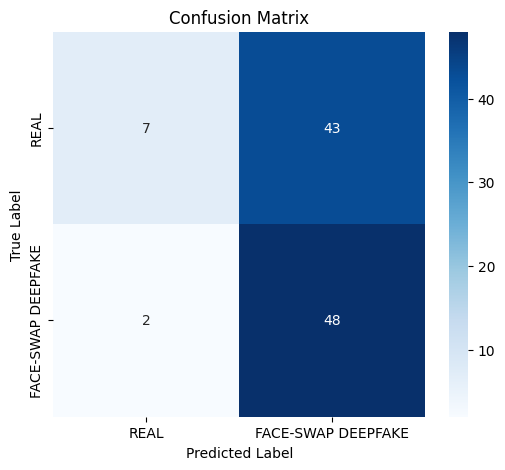


📊 Classification Report:
                    precision    recall  f1-score   support

              REAL       0.78      0.14      0.24        50
FACE-SWAP DEEPFAKE       0.53      0.96      0.68        50

          accuracy                           0.55       100
         macro avg       0.65      0.55      0.46       100
      weighted avg       0.65      0.55      0.46       100


📈 AUC Score: 0.4836


c:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\interpolate\_interpolate.py:701: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\interpolate\_interpolate.py:704: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


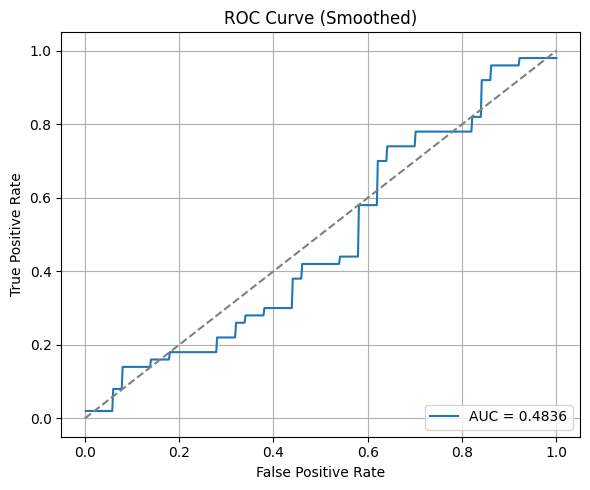

In [ ]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
from scipy.interpolate import interp1d


# Setup device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load model
def load_model(weights_path):
    model = DeepfakeClassifier()
    model.load_state_dict(torch.load(weights_path, map_location=device))
    model.to(device)
    model.eval()
    return model

# Path konfigurasi
model_path = "Model/AlexNet-BiLSTM_Wajah/AlexNet_64x192-BiLSTM_2_Wajah_1R1F.pth"
pt_folder = "Dataset_Skripsi/testing CNN-BiLSTM/Preprocessed_npy"
model = load_model(model_path)

classes = ['REAL', 'FACE-SWAP DEEPFAKE']
true_labels = []
predicted_labels = []
probs_class1 = []

# Loop seluruh file
for filename in sorted(os.listdir(pt_folder)):
    if not filename.endswith(".pt"):
        continue

    filepath = os.path.join(pt_folder, filename)
    data = torch.load(filepath)

    frames = torch.stack(data['frames']).unsqueeze(0).to(device)

    true_label = data['label'].item()

    with torch.no_grad():
        outputs = model(frames)
        probabilities = torch.softmax(outputs, dim=1).cpu().numpy()[0]
        predicted = int(np.argmax(probabilities))
        probs_class1.append(probabilities[1])

    print(f"{filename}: Predicted = {classes[predicted]}, True = {classes[true_label]}")

    true_labels.append(true_label)
    predicted_labels.append(predicted)

# Akurasi
total = len(true_labels)
correct = sum(p == t for p, t in zip(predicted_labels, true_labels))
accuracy = correct / total if total > 0 else 0
print(f"\n✅ Testing Accuracy: {accuracy * 100:.2f}% ({correct}/{total})")

# Confusion Matrix
cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print("\n📊 Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=classes))

# AUC Score
if len(set(true_labels)) == 2:
    auc_score = roc_auc_score(true_labels, probs_class1)
    print(f"\n📈 AUC Score: {auc_score:.4f}")

    # ROC Curve
    fpr, tpr, thresholds = roc_curve(true_labels, probs_class1)

    fpr_smooth = np.linspace(0, 1, 500)
    tpr_smooth = interp1d(fpr, tpr, kind='linear', fill_value="extrapolate")(fpr_smooth)

    # Plot
    plt.figure(figsize=(6, 5))
    plt.plot(fpr_smooth, tpr_smooth, label=f"AUC = {auc_score:.4f}")
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve (Smoothed)')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("\n⚠️ AUC tidak bisa dihitung karena hanya ada satu kelas di label.")

**Percobaan 8**

Full Conv Block (64, 192) -> ReLU

Weight Criterion 2:1

In [75]:
import torch
import torch.nn as nn

# Inisialisasi perangkat dan model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DeepfakeClassifier().to(device)

# Optimizer dan loss function
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
weights = torch.tensor([2.0, 1.0], device=device)  # bobot kelas REAL, DEEPFAKE
criterion = nn.CrossEntropyLoss(weight=weights)

c:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# Log
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

num_epochs = 40
best_val_loss = float('inf')

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    total_correct = 0
    total_samples = 0

    # Training
    for frames, labels in train_loader:
        frames = torch.stack(frames).to(device) if isinstance(frames, list) else frames.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(frames)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * frames.size(0)
        _, predicted = torch.max(outputs, 1)
        total_correct += (predicted == labels).sum().item()
        total_samples += labels.size(0)

    train_acc = total_correct / total_samples
    train_loss = running_loss / total_samples

    # Validasi
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for frames, labels in val_loader:
            frames = torch.stack(frames).to(device) if isinstance(frames, list) else frames.to(device)
            labels = labels.to(device)

            outputs = model(frames)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * frames.size(0)
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    val_acc = val_correct / val_total
    val_loss = val_loss / val_total

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    
    # Save model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'Model/AlexNet-BiLSTM_Wajah/AlexNet_64x192-BiLSTM_2_Wajah_2R1F.pth')
    
    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} "
          f"| Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

Epoch [1/40] Train Loss: 0.6948 | Train Acc: 0.5000 | Val Loss: 0.7095 | Val Acc: 0.4328
Epoch [2/40] Train Loss: 0.6635 | Train Acc: 0.5037 | Val Loss: 0.7329 | Val Acc: 0.4328
Epoch [3/40] Train Loss: 0.6564 | Train Acc: 0.5373 | Val Loss: 0.6817 | Val Acc: 0.4328
Epoch [4/40] Train Loss: 0.6450 | Train Acc: 0.5709 | Val Loss: 0.6748 | Val Acc: 0.4328
Epoch [5/40] Train Loss: 0.6558 | Train Acc: 0.5187 | Val Loss: 0.6907 | Val Acc: 0.4328
Epoch [6/40] Train Loss: 0.6488 | Train Acc: 0.5522 | Val Loss: 0.6804 | Val Acc: 0.4328
Epoch [7/40] Train Loss: 0.6429 | Train Acc: 0.5485 | Val Loss: 0.7245 | Val Acc: 0.4328
Epoch [8/40] Train Loss: 0.6414 | Train Acc: 0.5560 | Val Loss: 0.6553 | Val Acc: 0.5672
Epoch [9/40] Train Loss: 0.6281 | Train Acc: 0.5858 | Val Loss: 0.7040 | Val Acc: 0.5075
Epoch [10/40] Train Loss: 0.6168 | Train Acc: 0.6007 | Val Loss: 0.7202 | Val Acc: 0.4328
Epoch [11/40] Train Loss: 0.6364 | Train Acc: 0.5261 | Val Loss: 0.7124 | Val Acc: 0.4328
Epoch [12/40] Train

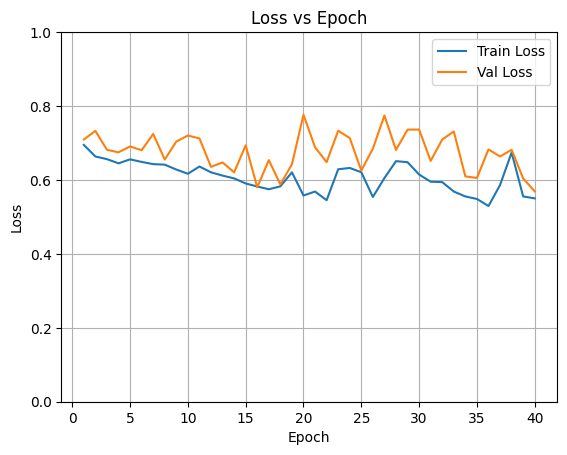

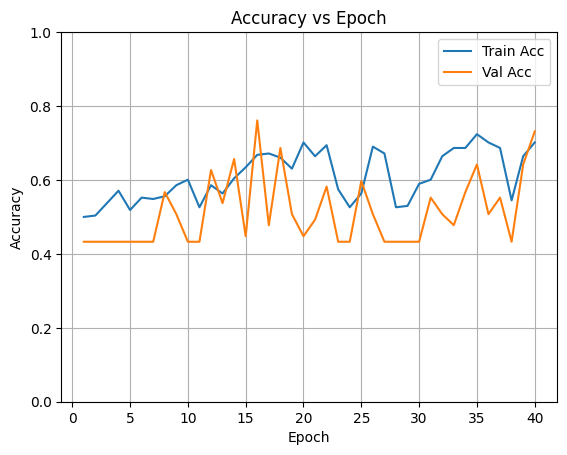

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, num_epochs + 1)

# Loss plot
plt.figure()
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.ylim(0, 1)  # Membatasi sumbu y dari 0 sampai 1
plt.legend()
plt.grid(True)
plt.show()

# Akurasi plot
plt.figure()
plt.plot(epochs, train_accuracies, label='Train Acc')
plt.plot(epochs, val_accuracies, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epoch')
plt.ylim(0, 1)  # Membatasi sumbu y dari 0 sampai 1
plt.legend()
plt.grid(True)
plt.show()

aabyjxwqyo.pt: Predicted = FACE-SWAP DEEPFAKE, True = FACE-SWAP DEEPFAKE
aaeflzzhvy.pt: Predicted = FACE-SWAP DEEPFAKE, True = FACE-SWAP DEEPFAKE
accfrqkrni.pt: Predicted = FACE-SWAP DEEPFAKE, True = FACE-SWAP DEEPFAKE
adfzvplbky.pt: Predicted = FACE-SWAP DEEPFAKE, True = FACE-SWAP DEEPFAKE
adrqlckutl.pt: Predicted = FACE-SWAP DEEPFAKE, True = FACE-SWAP DEEPFAKE
adsxwxeibr.pt: Predicted = FACE-SWAP DEEPFAKE, True = FACE-SWAP DEEPFAKE
ahencqpiin.pt: Predicted = FACE-SWAP DEEPFAKE, True = FACE-SWAP DEEPFAKE
alzbizkswy.pt: Predicted = FACE-SWAP DEEPFAKE, True = REAL
aqhbszcpal.pt: Predicted = FACE-SWAP DEEPFAKE, True = FACE-SWAP DEEPFAKE
baqledjaon.pt: Predicted = FACE-SWAP DEEPFAKE, True = FACE-SWAP DEEPFAKE
barbcborgl.pt: Predicted = FACE-SWAP DEEPFAKE, True = REAL
bfkzrgovsv.pt: Predicted = FACE-SWAP DEEPFAKE, True = REAL
bfljjbavig.pt: Predicted = FACE-SWAP DEEPFAKE, True = FACE-SWAP DEEPFAKE
bhqcqwcise.pt: Predicted = FACE-SWAP DEEPFAKE, True = REAL
bqwwkjlmgv.pt: Predicted = FACE-SW

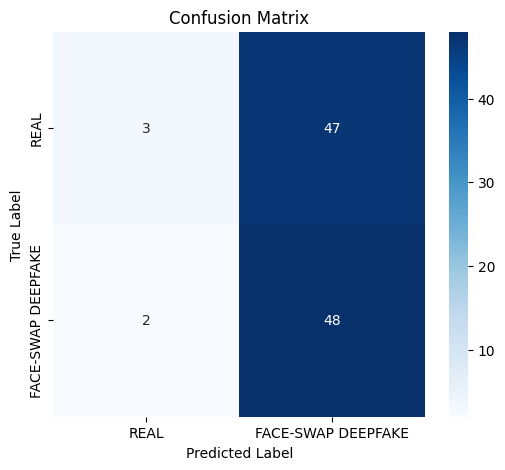


📊 Classification Report:
                    precision    recall  f1-score   support

              REAL       0.60      0.06      0.11        50
FACE-SWAP DEEPFAKE       0.51      0.96      0.66        50

          accuracy                           0.51       100
         macro avg       0.55      0.51      0.39       100
      weighted avg       0.55      0.51      0.39       100


📈 AUC Score: 0.4896


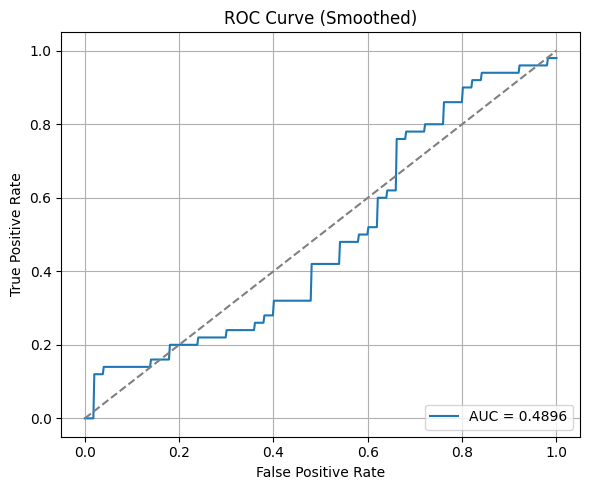

In [ ]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
from scipy.interpolate import interp1d


# Setup device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load model
def load_model(weights_path):
    model = DeepfakeClassifier()
    model.load_state_dict(torch.load(weights_path, map_location=device))
    model.to(device)
    model.eval()
    return model

# Path konfigurasi
model_path = "Model/AlexNet-BiLSTM_Wajah/AlexNet_64x192-BiLSTM_2_Wajah_2R1F.pth"
pt_folder = "Dataset_Skripsi/testing CNN-BiLSTM/Preprocessed_npy"
model = load_model(model_path)

classes = ['REAL', 'FACE-SWAP DEEPFAKE']
true_labels = []
predicted_labels = []
probs_class1 = []

# Loop seluruh file
for filename in sorted(os.listdir(pt_folder)):
    if not filename.endswith(".pt"):
        continue

    filepath = os.path.join(pt_folder, filename)
    data = torch.load(filepath)

    frames = torch.stack(data['frames']).unsqueeze(0).to(device)

    true_label = data['label'].item()

    with torch.no_grad():
        outputs = model(frames)
        probabilities = torch.softmax(outputs, dim=1).cpu().numpy()[0]
        predicted = int(np.argmax(probabilities))
        probs_class1.append(probabilities[1])

    print(f"{filename}: Predicted = {classes[predicted]}, True = {classes[true_label]}")

    true_labels.append(true_label)
    predicted_labels.append(predicted)

# Akurasi
total = len(true_labels)
correct = sum(p == t for p, t in zip(predicted_labels, true_labels))
accuracy = correct / total if total > 0 else 0
print(f"\n✅ Testing Accuracy: {accuracy * 100:.2f}% ({correct}/{total})")

# Confusion Matrix
cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print("\n📊 Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=classes))

# AUC Score
if len(set(true_labels)) == 2:
    auc_score = roc_auc_score(true_labels, probs_class1)
    print(f"\n📈 AUC Score: {auc_score:.4f}")

    # ROC Curve
    fpr, tpr, thresholds = roc_curve(true_labels, probs_class1)

    fpr_smooth = np.linspace(0, 1, 500)
    tpr_smooth = interp1d(fpr, tpr, kind='linear', fill_value="extrapolate")(fpr_smooth)

    # Plot
    plt.figure(figsize=(6, 5))
    plt.plot(fpr_smooth, tpr_smooth, label=f"AUC = {auc_score:.4f}")
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve (Smoothed)')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("\n⚠️ AUC tidak bisa dihitung karena hanya ada satu kelas di label.")